In [1]:
# import libraries
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib
from tqdm import tqdm

# path
DATA_PATH = r"C:\Users\Lakshya Gupta\Downloads\train(1)(train(1)).csv"
IMAGE_DIR = IMAGE_DIR = r"E:\cdc_project\images_mapbox_zoom18"  
OUTPUT_DIR = "processed_data"

os.makedirs(OUTPUT_DIR, exist_ok=True)

In [3]:
# load the datset
print("Loading data...")
try:
    df = pd.read_csv(DATA_PATH)
    print(f"Data loaded successfully. Shape: {df.shape}")
except FileNotFoundError:
    print(f" Error: Could not find file at {DATA_PATH}")
    # Stop execution if file not found (in a real notebook you'd stop here)

Loading data...
Data loaded successfully. Shape: (16209, 21)


In [4]:
df.head()

id             date   price  bedrooms  bathrooms  sqft_living  \
0  9117000170  20150505T000000  268643         4       2.25         1810   
1  6700390210  20140708T000000  245000         3       2.50         1600   
2  7212660540  20150115T000000  200000         4       2.50         1720   
3  8562780200  20150427T000000  352499         2       2.25         1240   
4  7760400350  20141205T000000  232000         3       2.00         1280   

   sqft_lot  floors  waterfront  view  ...  grade  sqft_above  sqft_basement  \
0      9240     2.0           0     0  ...      7        1810              0   
1      2788     2.0           0     0  ...      7        1600              0   
2      8638     2.0           0     0  ...      8        1720              0   
3       705     2.0           0     0  ...      7        1150             90   
4     13356     1.0           0     0  ...      7        1280              0   

   yr_built  yr_renovated  zipcode      lat     long  sqft_living15  \
0      1961             0    98055  47.4362 -122.187           1660   
1      1992             0    98031  47.4034 -122.187           1720   
2      1994             0    98003  47.2704 -122.313           1870   
3      2009             0    98027  47.5321 -122.073           1240   
4      1994             0    98042  47.3715 -122.074           1590   

   sqft_lot15  
0        9240  
1        3605  
2        7455  
3         750  
4        8071  

[5 rows x 21 columns]

In [5]:
# Clean IDs
df['id'] = df['id'].astype(str).replace(r'\.0$', '', regex=True)
print(f"Initial Shape: {df.shape}")

Initial Shape: (16209, 21)


In [11]:
# Get the first ID from the CSV
csv_id = df['id'].iloc[0]
print(f"CSV thinks the ID is:  '{csv_id}'")

# 4. Check what file Python is looking for
expected_filename = f"{csv_id}.jpg"
full_path = os.path.join(IMAGE_DIR, expected_filename)
print(f" Python is looking for: {full_path}")

# 5. Check what is ACTUALLY in the folder
print(f"\nChecking Folder Content:")
if os.path.exists(IMAGE_DIR):
    files = os.listdir(IMAGE_DIR)
    print(f"Folder found! Contains {len(files)} files.")
    print(f"First 5 files in folder:  files[:5]")
    
    if expected_filename in files:
        print(f"MATCH FOUND! The file '{expected_filename}' is there.")
    else:
        print(f"MATCH FAILED. '{expected_filename}' is NOT in the list.")
        print("(Compare the 'CSV ID' above with the 'First 5 files'. Do they look different?)")
else:
    print("Critical Error: The folder path is invalid.")

CSV thinks the ID is:  '9117000170'
 Python is looking for: E:\cdc_project\images_mapbox_zoom18\9117000170.jpg

Checking Folder Content:
Folder found! Contains 16092 files.
First 5 files in folder:  files[:5]
MATCH FOUND! The file '9117000170.jpg' is there.


In [ ]:
# We remove rows where the image failed to download
print("\nChecking for matching images...")

valid_rows = []
for idx, row in tqdm(df.iterrows(), total=len(df)):
    img_path = os.path.join(IMAGE_DIR, f"{row['id']}.jpg")
    
    # Check: Does file exist and Is it valid (size > 0)?
    if os.path.exists(img_path) and os.path.getsize(img_path) > 0:
        valid_rows.append(idx)


# Filter the dataframe to only keep rows with valid images
df_clean = df.loc[valid_rows].copy()
print(
    f"Rows with valid images: {len(df_clean)} "
    f"(Dropped {len(df) - len(df_clean)} rows)"
)


Checking for matching images...


100%|██████████| 16209/16209 [00:01<00:00, 8168.30it/s]

Rows with valid images: 16191 (Dropped 18 rows)


In [13]:
df_clean.isnull().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [14]:
sum(df_clean.isna().sum(axis=1) > 0)


0

In [15]:
column_names= df_clean.columns.tolist()
print(column_names)

['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15']


In [16]:
# OUTLIER REMOVAL

df_clean = df_clean[(df_clean['bedrooms'] > 0) & (df_clean['bedrooms'] < 11)]
df_clean = df_clean[df_clean['price'] < 7500000] 

# log transformation - skewed features to help the model
cols_to_log = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_living15', 'sqft_lot15']

for col in cols_to_log:
    df_clean[f'{col}_log'] = np.log1p(df_clean[col])

# Transform Target
df_clean['price_log'] = np.log1p(df_clean['price'])

In [17]:
# Calculate the average latitude and longitude of your dataset
CITY_LAT = df_clean['lat'].mean()
CITY_LON = df_clean['long'].mean()

print(f"Center of Data: {CITY_LAT}, {CITY_LON}")

Center of Data: 47.560778035968106, -122.21405518818366


In [18]:
# Find the latitude/longitude of the top 10% most expensive houses
rich_area = df_clean[df_clean['price'] > df_clean['price'].quantile(0.90)]
CITY_LAT = rich_area['lat'].mean()
CITY_LON = rich_area['long'].mean()

print(f"Financial Center: {CITY_LAT}, {CITY_LON}")

Financial Center: 47.61751600741656, -122.21626081582201


In [19]:
current_year = df_clean['yr_built'].max()
print(current_year)

print("Size Percentiles :")
print(df_clean['sqft_living'].quantile([0.5, 0.75, 0.9, 0.95, 0.99]))

print("\nGrade Counts :")
print(df_clean['grade'].value_counts().sort_index())

print("\nView Counts :")
print(df_clean['view'].value_counts().sort_index())


2015
Size Percentiles :
0.50    1910.0
0.75    2547.0
0.90    3240.0
0.95    3740.0
0.99    4920.0
Name: sqft_living, dtype: float64

Grade Counts :
grade
3        3
4       23
5      182
6     1511
7     6752
8     4555
9     1941
10     857
11     286
12      62
13       9
Name: count, dtype: int64

View Counts :
view
0    14579
1      254
2      742
3      373
4      233
Name: count, dtype: int64


In [20]:
# Distance to city center (proxy for accessibility)
df_clean['dist_to_city_center'] = np.sqrt(
    (df_clean['lat'] - CITY_LAT)**2 +
    (df_clean['long'] - CITY_LON)**2
)

# Relative size compared to plot area (density)
df_clean['living_to_lot_ratio'] = (
    df_clean['sqft_living'] / (df_clean['sqft_lot'] + 1)
)

# Size comparison with nearby houses
df_clean['neighbor_comparison'] = (
    df_clean['sqft_living'] / (df_clean['sqft_living15'] + 1)
)

# Room spaciousness
df_clean['sqft_per_bedroom'] = (
    df_clean['sqft_living'] / (df_clean['bedrooms'] + 1)
)


# Log transforms (handle skew & outliers)
df_clean['dist_to_city_center_log'] = np.log1p(df_clean['dist_to_city_center'])
df_clean['living_to_lot_ratio_log'] = np.log1p(df_clean['living_to_lot_ratio'])
df_clean['neighbor_comparison_log'] = np.log1p(df_clean['neighbor_comparison'])
df_clean['sqft_per_bedroom_log'] = np.log1p(df_clean['sqft_per_bedroom'])



df_clean['date'] = pd.to_datetime(df_clean['date'])

df_clean['sale_year'] = df_clean['date'].dt.year
df_clean['sale_month'] = df_clean['date'].dt.month

# Cyclical encoding for month
df_clean['month_sin'] = np.sin(2 * np.pi * df_clean['sale_month'] / 12)
df_clean['month_cos'] = np.cos(2 * np.pi * df_clean['sale_month'] / 12)


# House age and effective age (accounts for renovation)
df_clean['house_age'] = current_year - df_clean['yr_built']
df_clean['effective_age'] = np.where(
    df_clean['yr_renovated'] > 0,
    current_year - df_clean['yr_renovated'],
    df_clean['house_age']
)

# Luxury segment indicator
df_clean['is_luxury'] = (
    (df_clean['sqft_living'] > 3500) &
    (df_clean['grade'] >= 10) &
    (df_clean['view'] > 2)
).astype(int)

# Waterfront flag
df_clean['is_waterfront'] = (df_clean['waterfront'] == 1).astype(int)

# Renovation impact (recent renovations weighted higher)
df_clean['renovation_impact'] = np.where(
    df_clean['yr_renovated'] > 0,
    1 / (2024 - df_clean['yr_renovated'] + 1),
    0
)

# Basement availability
df_clean['has_basement'] = (df_clean['sqft_basement'] > 0).astype(int)


# High grade combined with large living area
df_clean['grade_living_interaction'] = (
    df_clean['grade'] * np.log1p(df_clean['sqft_living'])
)

# Size difference compared to neighbors
df_clean['size_diff_from_neighbors'] = (
    df_clean['sqft_living'] - df_clean['sqft_living15']
)


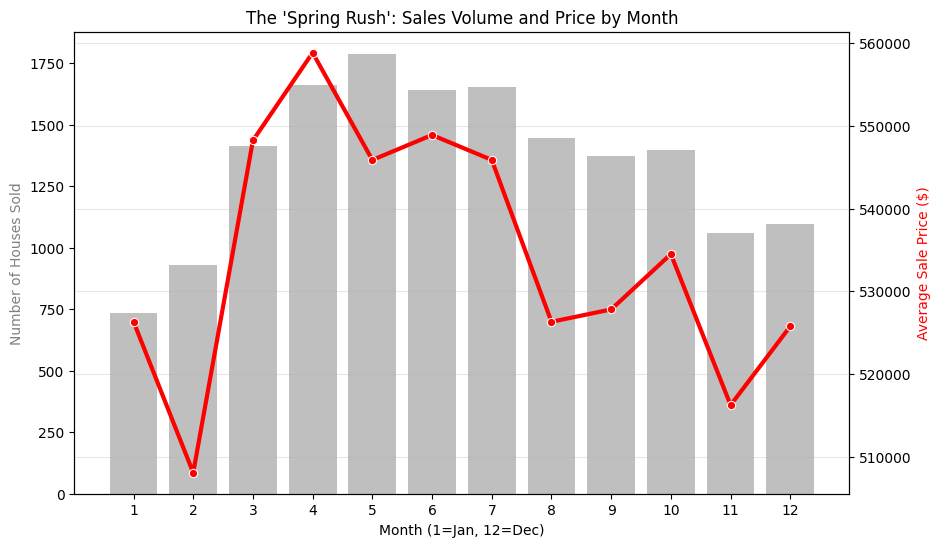

In [21]:
#  Calculate Average Price & Volume per Month
monthly_stats = df_clean.groupby('sale_month').agg({
    'price': 'mean',
    'id': 'count'
}).reset_index()

# Create the "Proof" Plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar Chart: Number of Sales (Volume)
sns.barplot(x='sale_month', y='id', data=monthly_stats, alpha=0.5, color='grey', ax=ax1)
ax1.set_ylabel('Number of Houses Sold', color='grey')
ax1.set_xlabel('Month (1=Jan, 12=Dec)')

# Line Chart: Average Price
ax2 = ax1.twinx()
sns.lineplot(x=monthly_stats.index, y='price', data=monthly_stats, marker='o', color='red', linewidth=3, ax=ax2)
ax2.set_ylabel('Average Sale Price ($)', color='red')

plt.title("The 'Spring Rush': Sales Volume and Price by Month")
plt.grid(True, alpha=0.3)
plt.show()

In [22]:
# Convert date to datetime object
df_clean['date'] = pd.to_datetime(df_clean['date'])

# Extract Month (1-12)
df_clean['sale_month'] = df_clean['date'].dt.month

# Optional: Create a "Peak Season" flag (Summer months)
df_clean['is_peak_season'] = df_clean['sale_month'].between(4, 8).astype(int)

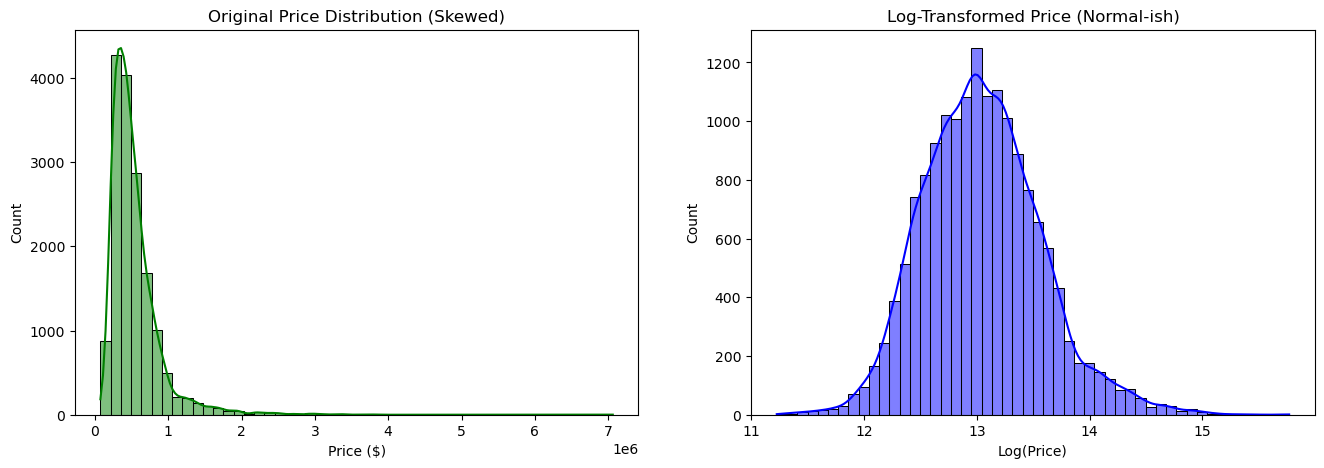

In [ ]:
# Price Distribution (Log vs Normal)
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
sns.histplot(df_clean['price'], bins=50, kde=True, ax=ax[0], color='green')
ax[0].set_title("Original Price Distribution (Skewed)")
ax[0].set_xlabel("Price ($)")

sns.histplot(np.log1p(df_clean['price']), bins=50, kde=True, ax=ax[1], color='blue')
ax[1].set_title("Log-Transformed Price (Normal-ish)")
ax[1].set_xlabel("Log(Price)")
plt.show()

###### Price Distribution Insight: The original prices were heavily skewed, but the log transform fixed them into a normal bell curve, which makes it much easier for the model to predict.

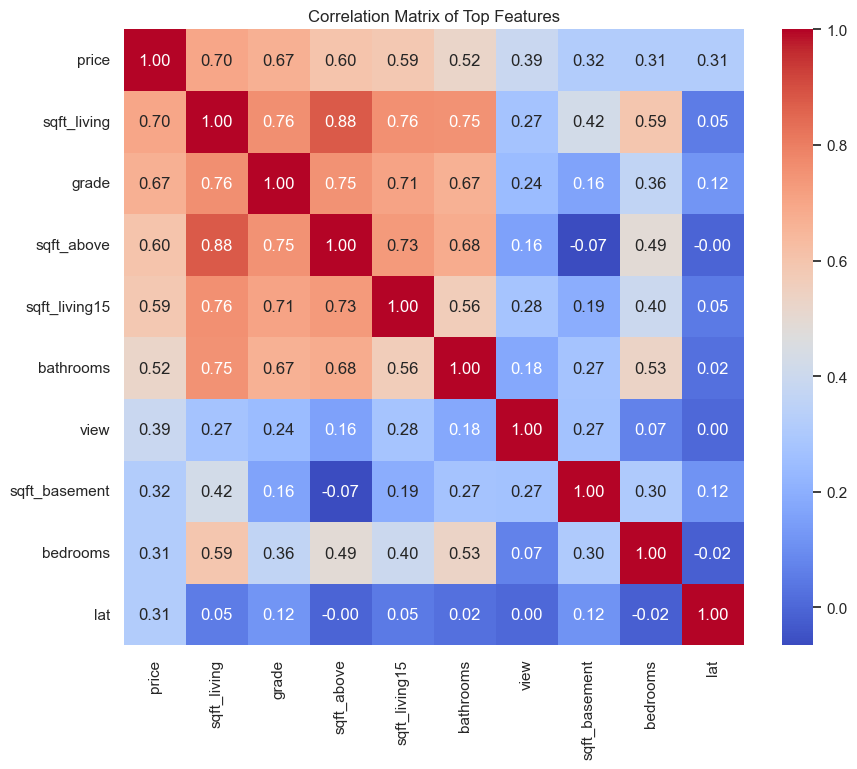

In [ ]:
# 2. Correlation Heatmap(10)
plt.figure(figsize=(10, 8))
cols = ['price', 'sqft_living', 'grade', 'sqft_above', 'sqft_living15', 
        'bathrooms', 'view', 'sqft_basement', 'bedrooms', 'lat']
corr = df_clean[cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Top Features")
plt.show()

###### Correlation Insight: Size and construction quality (grade) are the strongest drivers of price, far outweighing the number of bedrooms or bathrooms.

C:\Users\Lakshya Gupta\AppData\Local\Temp\ipykernel_21812\3579615437.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='grade', y='price', data=df_clean, palette="viridis")


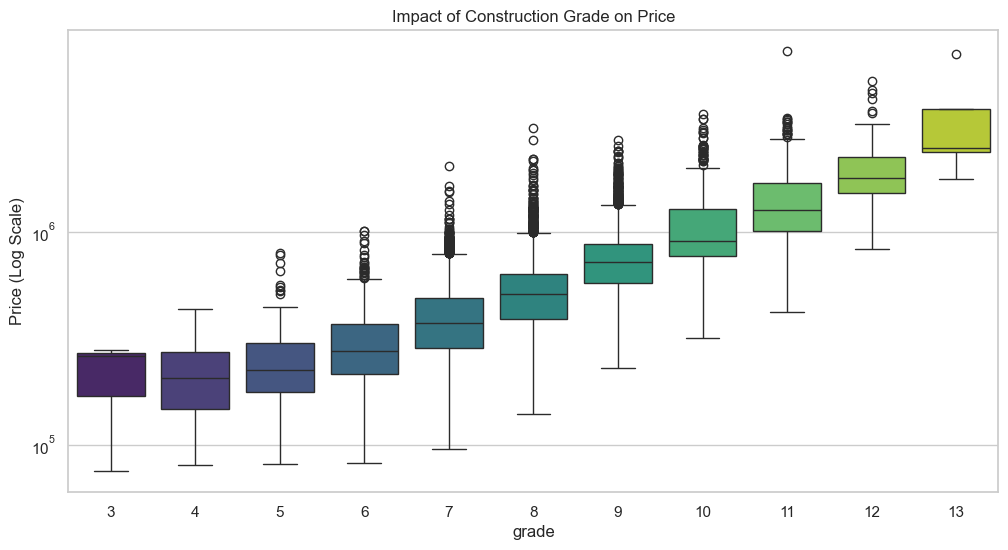

In [ ]:
# 3. Price vs. Construction Grade (Boxplot)
plt.figure(figsize=(12, 6))
sns.boxplot(x='grade', y='price', data=df_clean, palette="viridis")
plt.title("Impact of Construction Grade on Price")
plt.yscale('log') # Log scale makes it easier to see the trend
plt.ylabel("Price (Log Scale)")
plt.show()

###### Construction Grade Insight: Construction grade shows a clear exponential relationship with price; as quality improves, the value skyrockets, especially in the luxury tier (Grade 10+)

C:\Users\Lakshya Gupta\AppData\Local\Temp\ipykernel_24012\3139648137.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='grade', y='neighbor_comparison', data=df_clean[df_clean['neighbor_comparison'] < 3],


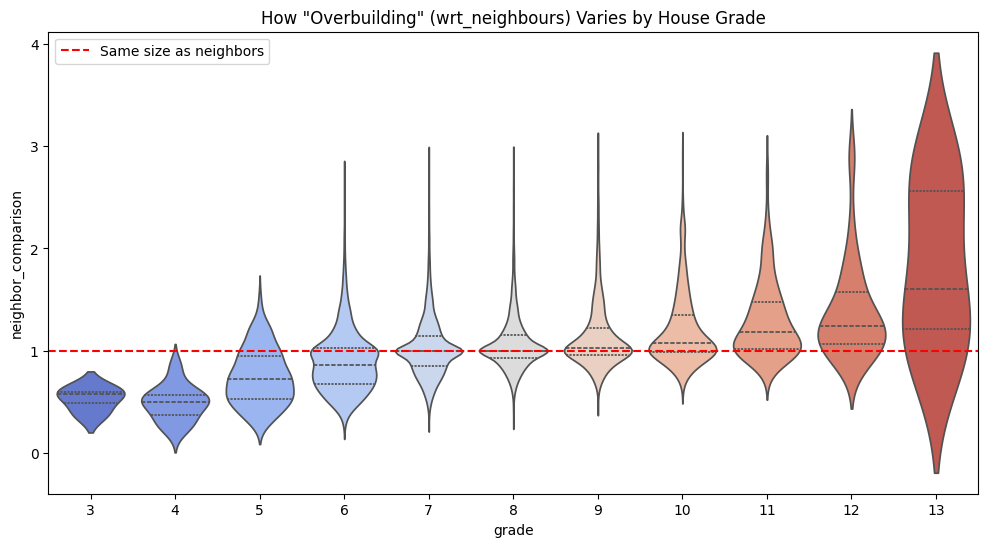

In [23]:
plt.figure(figsize=(12, 6))
sns.violinplot(x='grade', y='neighbor_comparison', data=df_clean[df_clean['neighbor_comparison'] < 3], 
               palette='coolwarm', inner="quart")
plt.axhline(1, color='red', linestyle='--', label='Same size as neighbors')
plt.title('How "Overbuilding" (wrt_neighbours) Varies by House Grade')
plt.legend()
plt.show()

###### Neighbor Comparison Insight: There is a clear trend where high-grade luxury homes are significantly larger than their neighbors (overbuilt), while lower-grade homes typically fall below the neighborhood size average.

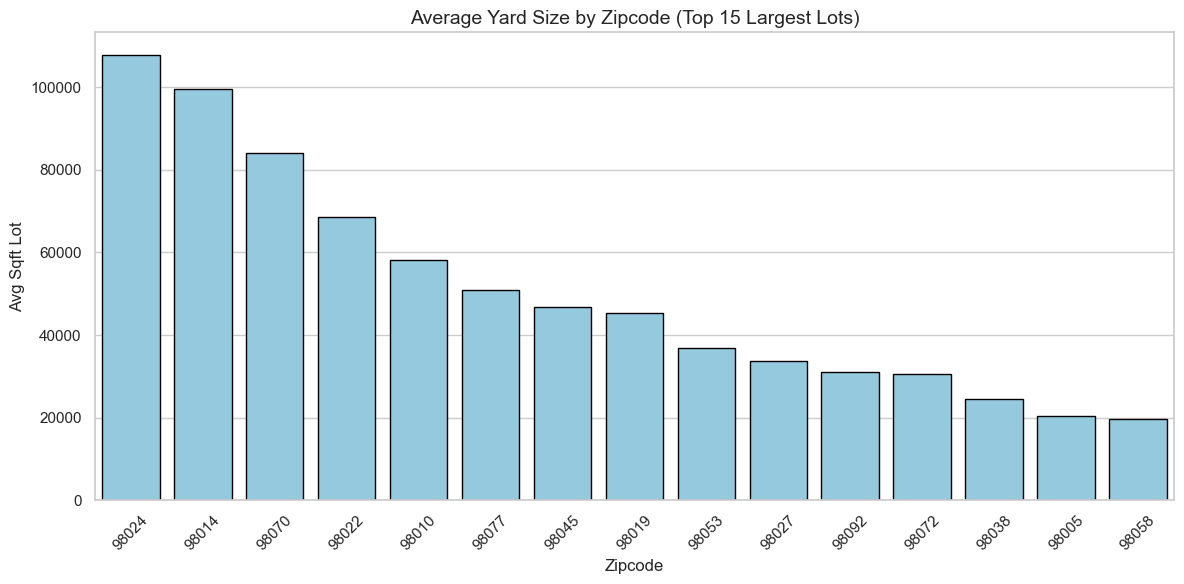

In [ ]:
plt.figure(figsize=(12, 6))

# 1. Calculate Average Yard Size (sqft_lot) per Zipcode
yard_size_by_zip = df_clean.groupby('zipcode')['sqft_lot'].mean().sort_values(ascending=False).head(15)
sns.barplot(x=yard_size_by_zip.index.astype(str), y=yard_size_by_zip.values, color='skyblue', edgecolor='black')

plt.title('Average Yard Size by Zipcode (Top 15 Largest Lots)', fontsize=14)
plt.xlabel('Zipcode', fontsize=12)
plt.ylabel('Avg Sqft Lot', fontsize=12)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

###### Yard Size Insight: Location dictates density: specific zip codes like 98024 feature massive estate-sized lots (over 100k sqft), clearly separating rural luxury zones from denser urban neighborhoods.

C:\Users\Lakshya Gupta\AppData\Local\Temp\ipykernel_21812\100015367.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='condition', y='price', data=df_clean, palette='viridis')


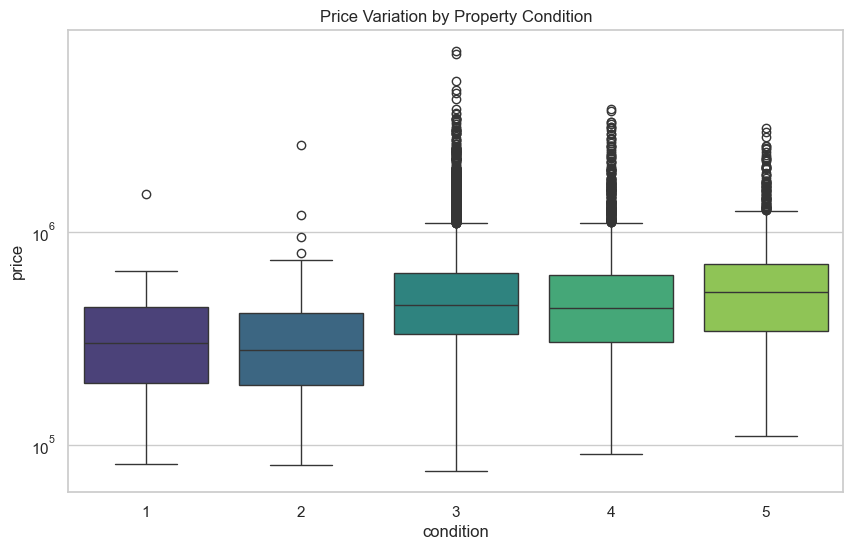

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='condition', y='price', data=df_clean, palette='viridis')
plt.title('Price Variation by Property Condition')
plt.yscale('log') 

plt.show()

###### Property Condition Insight: While higher condition scores generally correlate with higher prices, 'Average' condition (3) shows the widest price variance, suggesting location often trumps condition for high-value properties.

C:\Users\Lakshya Gupta\AppData\Local\Temp\ipykernel_21812\1933551771.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='waterfront', y='price', data=df, palette="Set2")


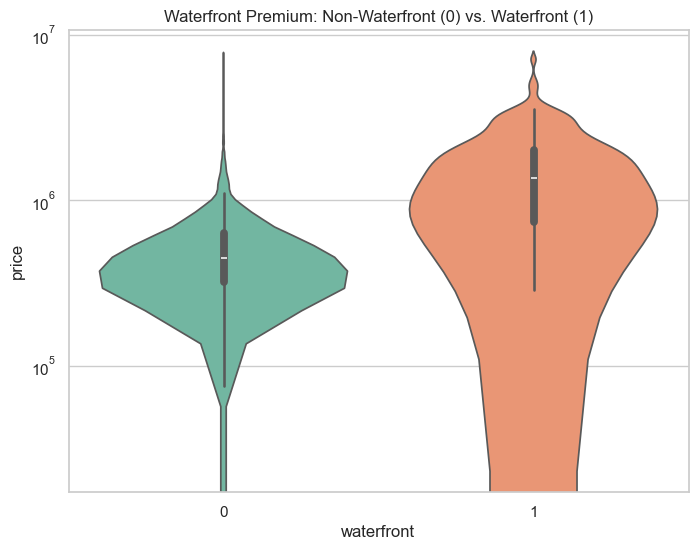

In [ ]:
plt.figure(figsize=(8, 6))
sns.violinplot(x='waterfront', y='price', data=df, palette="Set2")
plt.title("Waterfront Premium: Non-Waterfront (0) vs. Waterfront (1)")
plt.yscale('log')
plt.show()

###### Waterfront Premium Insight: Waterfront status is a massive value multiplier; the plot proves it shifts the entire price distribution upward, creating a distinct luxury tier that separates these homes from the rest of the market.

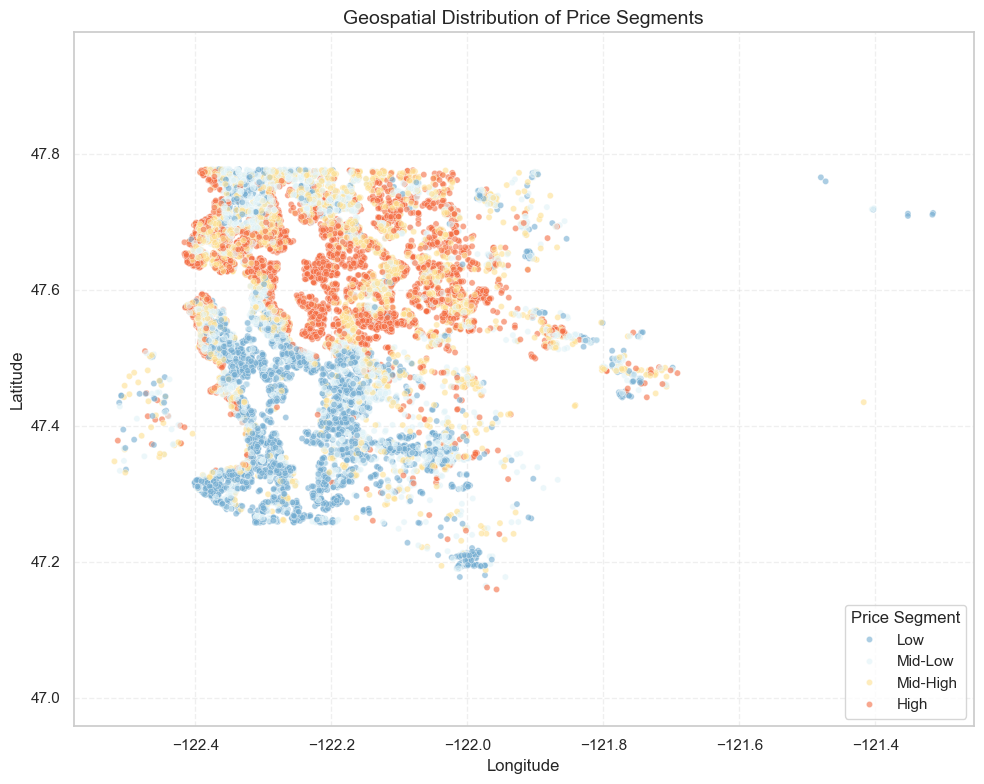

In [ ]:
plt.figure(figsize=(10, 8))
df_clean['price_segment'] = pd.qcut(df_clean['price'], q=4, labels=['Low', 'Mid-Low', 'Mid-High', 'High'])


sns.scatterplot(
    x='long', 
    y='lat', 
    hue='price_segment', 
    data=df_clean, 
    palette='RdYlBu_r', 
    alpha=0.6,         
    s=20                
)

plt.title('Geospatial Distribution of Price Segments', fontsize=14)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.legend(title='Price Segment', loc='lower right')
plt.axis('equal') 
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

###### Geospatial Insight: The map reveals a stark North-South divide in pricing, with high-value luxury homes clustered near the northern waterfronts and affordable housing concentrated in the southern inland regions

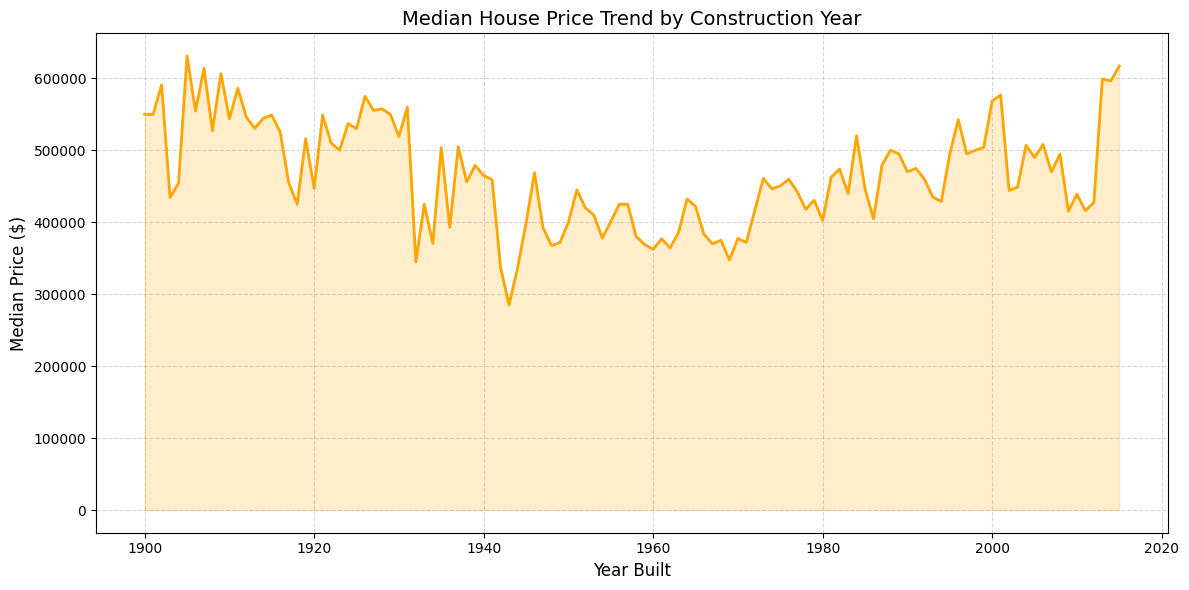

In [24]:
plt.figure(figsize=(12, 6))
price_per_year = df_clean.groupby('yr_built')['price'].median()
sns.lineplot(x=price_per_year.index, y=price_per_year.values, color='orange', linewidth=2)
plt.fill_between(price_per_year.index, price_per_year.values, color='orange', alpha=0.2)

plt.title('Median House Price Trend by Construction Year', fontsize=14)
plt.xlabel('Year Built', fontsize=12)
plt.ylabel('Median Price ($)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

###### Construction Year Insight: The chart reveals a distinct 'smile curve' where both historic pre-war homes and modern builds command high premiums, while mid-century properties see a significant dip in value.

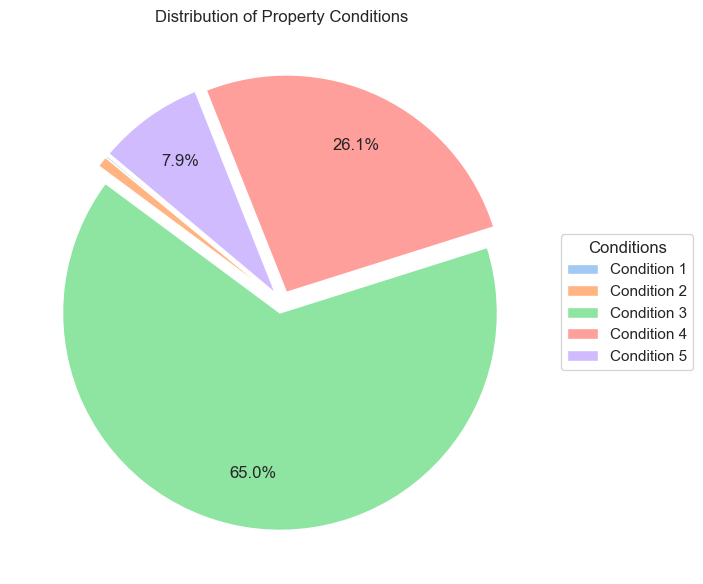

In [ ]:
colors = sns.color_palette('pastel')[0:5]
plt.figure(figsize=(10, 6))
def my_autopct(pct):
    return ('%1.1f%%' % pct) if pct > 2 else ''

wedges, texts, autotexts = plt.pie(
    condition_counts, 
    labels=None,  
    autopct=my_autopct, 
    startangle=140, 
    colors=colors, 
    explode=[0.05] * len(condition_counts),
    pctdistance=0.75
)
plt.legend(
    wedges, 
    labels, 
    title="Conditions", 
    loc="center left", 
    bbox_to_anchor=(1, 0, 0.5, 1) # Moves legend to the right
)

plt.title('Distribution of Property Conditions')
plt.tight_layout()
plt.show()

###### Property Condition Distribution Insight: The market is dominated by 'average' condition homes (65%), making top-tier quality (Condition 5) a rare feature (only 8%) that likely commands a scarcity premium

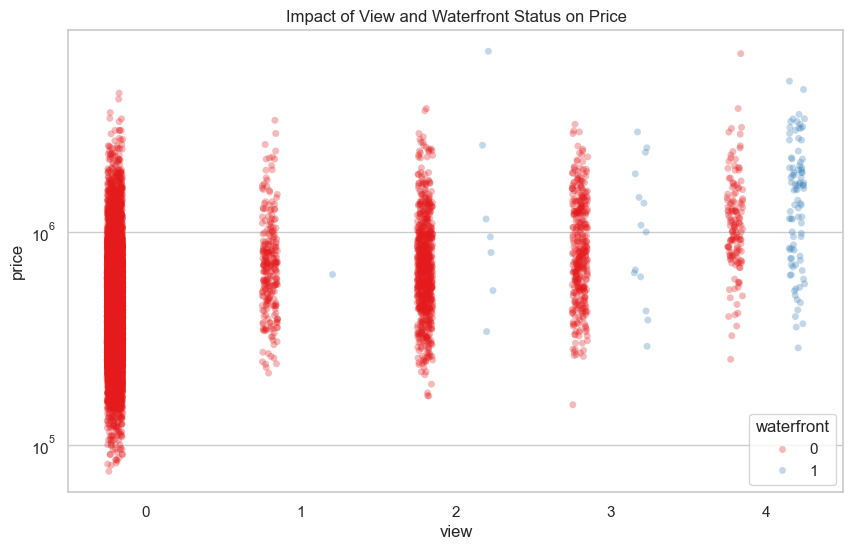

In [94]:
plt.figure(figsize=(10, 6))
sns.stripplot(x='view', y='price', hue='waterfront', 
              data=df_clean, dodge=True, alpha=0.3, palette='Set1')
plt.title('Impact of View and Waterfront Status on Price')
plt.yscale('log')
plt.show()

###### View & Waterfront Insight: Better views consistently drive prices up, but waterfront homes (blue) sit in a league of their own, almost exclusively dominating the highest view category and top price tier.

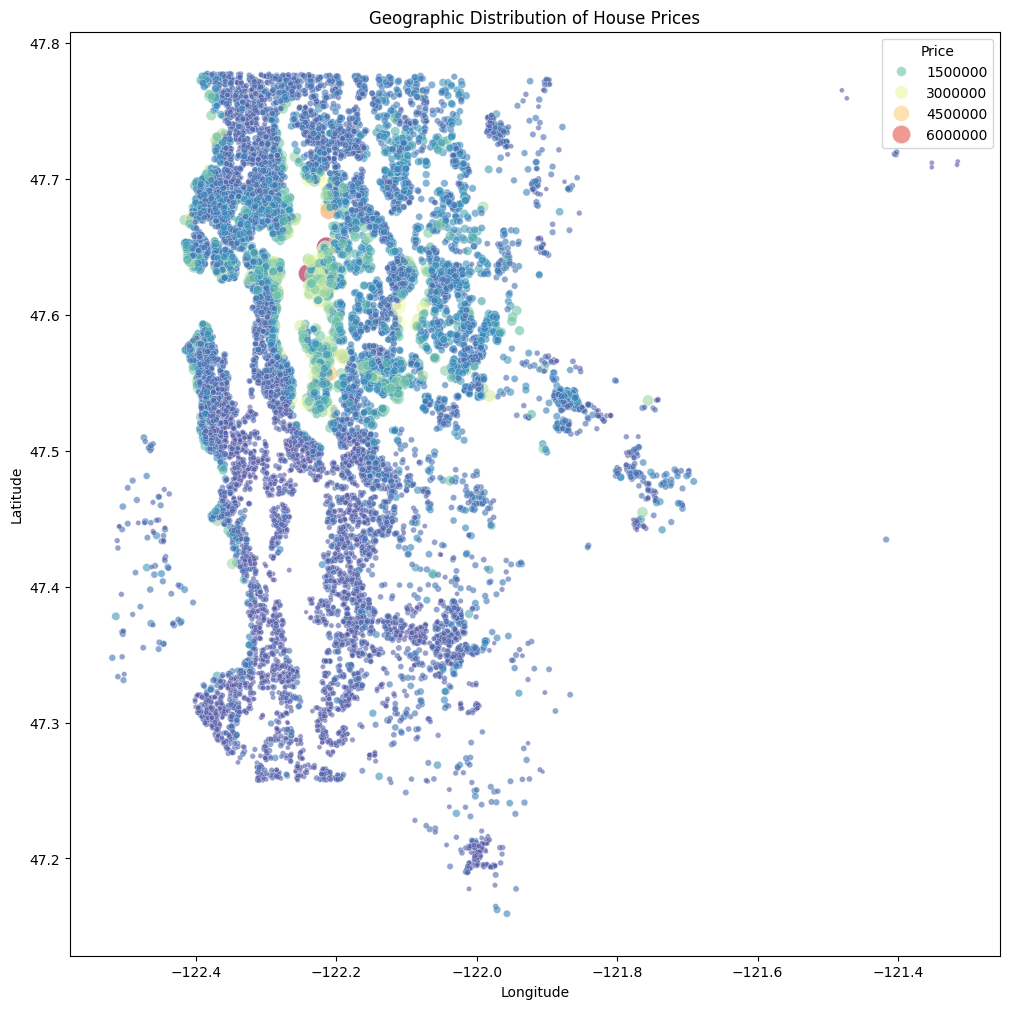

In [25]:

plt.figure(figsize=(12, 12))
sns.scatterplot(x='long', y='lat', hue='price', data=df_clean, 
                palette='Spectral_r', size='price', sizes=(10, 200), alpha=0.6)
plt.title("Geographic Distribution of House Prices")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title="Price")
plt.show()

###### Geographic Distribution Insight: The map reveals a stark north-south divide, with luxury properties (red/orange) clustered tightly along the northern waterfronts, while affordable homes dominate the southern inland areas.

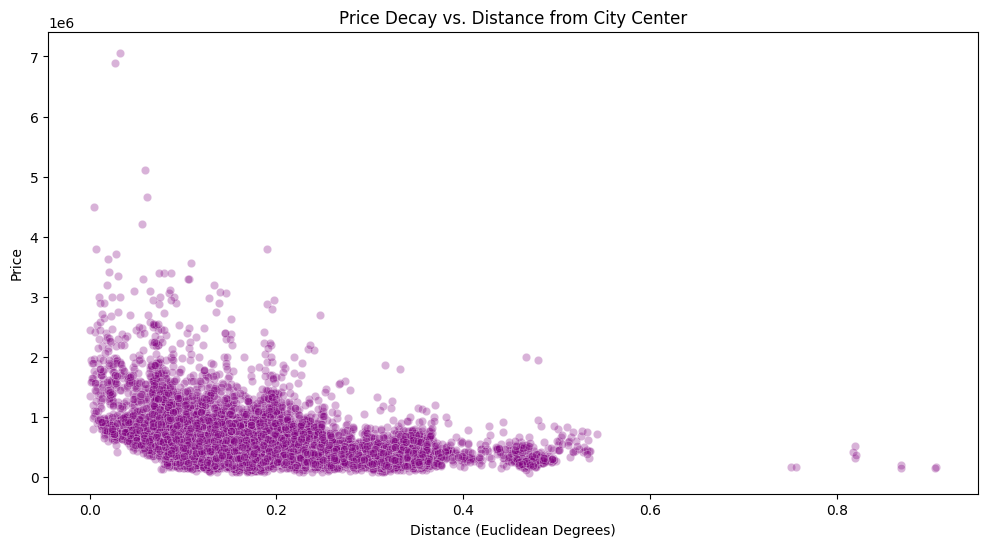

In [26]:
df_clean['dist_to_center'] = np.sqrt((df_clean['lat'] - CITY_LAT)**2 + (df_clean['long'] - CITY_LON)**2)

plt.figure(figsize=(12, 6))
sns.scatterplot(x='dist_to_center', y='price', data=df_clean, alpha=0.3, color='purple')
plt.title("Price Decay vs. Distance from City Center")
plt.xlabel("Distance (Euclidean Degrees)")
plt.ylabel("Price")
plt.show()

###### Distance Decay Insight: "The chart confirms a sharp price decay as distance from the city center increases, with the highest premiums and volatility concentrated within a tight 0.2-degree radius of the urban core."

In [28]:
import joblib
scaler = joblib.load("processed_data/scaler.pkl")
saved_scale_cols = joblib.load("processed_data/scale_cols.pkl")

final_features = [
    'lat', 'long', 'zip_wealth', 'cluster_wealth', 'dist_to_city_center_log',
    'sqft_living_log', 'sqft_lot_log', 'sqft_above_log', 
    'sqft_living15_log', 'sqft_lot15_log', 'sqft_per_bedroom_log',
    'living_to_lot_ratio_log', 'size_diff_from_neighbors',
    'grade_living_interaction', 'view', 'condition', 'effective_age',
    'neighbor_comparison_log', 'month_sin', 'month_cos', 'bathrooms'
]

missing_in_scaler = [f for f in final_features if f not in saved_scale_cols]

if missing_in_scaler:
    print(f" DANGER: These features are in your NN but were NOT scaled: {missing_in_scaler}")
else:
    print("All good! Your scaler and model features are perfectly aligned.")

All good! Your scaler and model features are perfectly aligned.


In [30]:
def plot_image_grid(ids, title):
    """Helper to plot a grid of 5 satellite images"""
    plt.figure(figsize=(20, 4))
    plt.suptitle(title, fontsize=16)
    
    for i, property_id in enumerate(ids[:5]):
        img_path = os.path.join(IMAGE_DIR, f"{property_id}.jpg")
        plt.subplot(1, 5, i+1)
        try:
            img = mpimg.imread(img_path)
            plt.imshow(img)
            plt.axis('off')
            plt.title(f"ID: {property_id}")
        except FileNotFoundError:
            plt.text(0.5, 0.5, "Image Not Found", ha='center')
            plt.axis('off')
    plt.show()

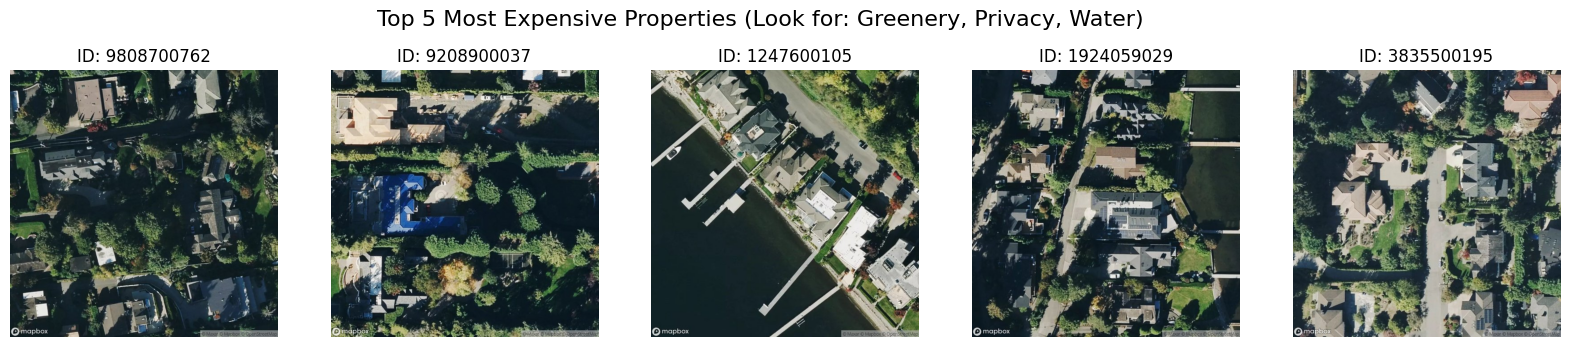

In [32]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
top_houses = df_clean.nlargest(5, 'price')['id'].values
plot_image_grid(top_houses, "Top 5 Most Expensive Properties (Look for: Greenery, Privacy, Water)")

###### Visual Analysis Insight: Satellite imagery confirms that high-value properties exhibit distinct visual features recoverable by the CNN, such as private waterfront docks, swimming pools, and extensive privacy landscaping.

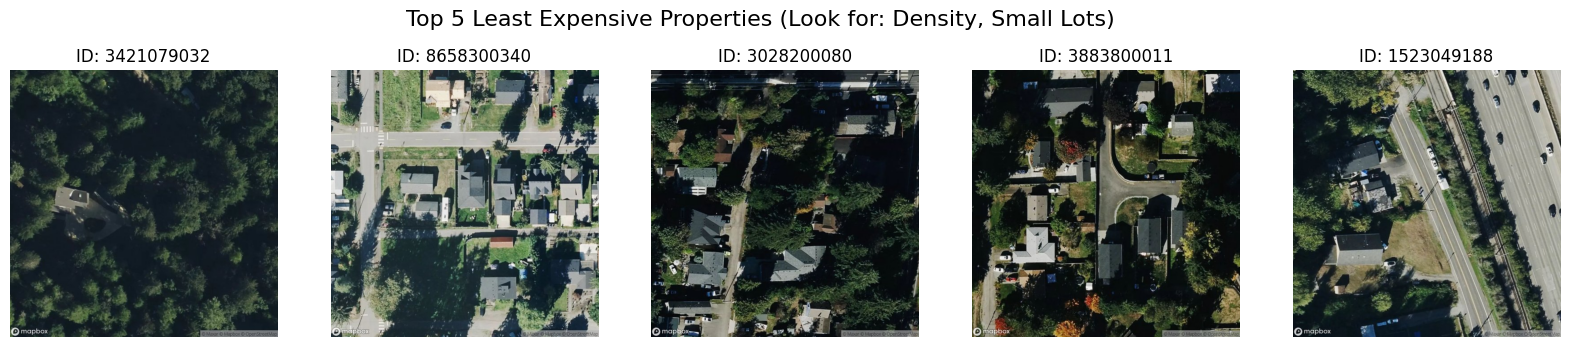

In [33]:
bottom_houses = df_clean.nsmallest(5, 'price')['id'].values
plot_image_grid(bottom_houses, "Top 5 Least Expensive Properties (Look for: Density, Small Lots)")

###### Satellite Imagery Insight: The visual contrast is striking: expensive homes clearly signal their value through visible pools, private docks, and lush privacy, while cheaper properties are defined by small lots and high density.

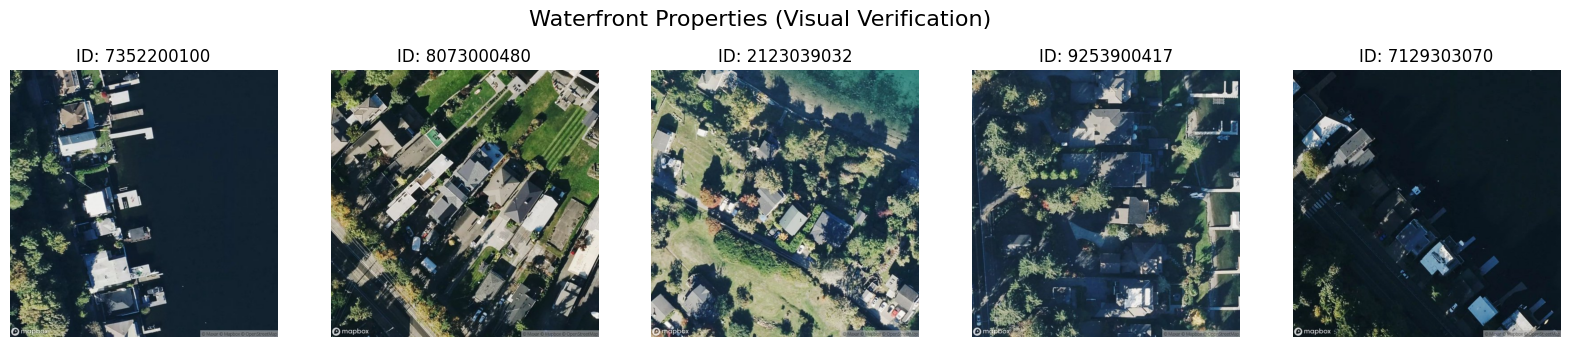

In [34]:
water_houses = df_clean[df_clean['waterfront'] == 1].sample(5, random_state=42)['id'].values
plot_image_grid(water_houses, "Waterfront Properties (Visual Verification)")

###### Waterfront Visual Insight: The satellite imagery verifies the integrity of the 'waterfront' label, with every sample displaying clear visual markers like shorelines, private docks, and blue water features that the CNN can easily distinguish from inland properties.

<Figure size 1200x600 with 0 Axes>

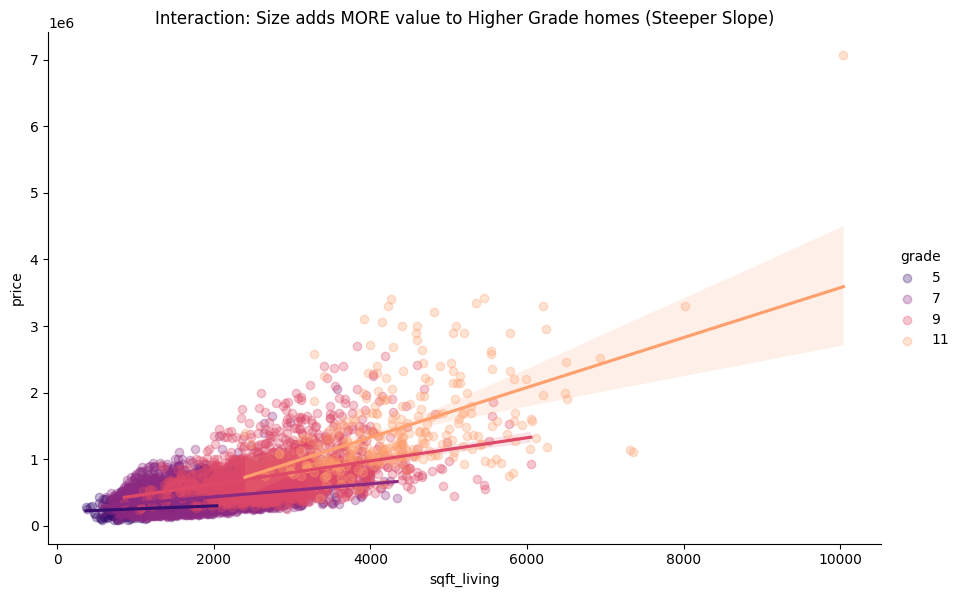

In [35]:
plt.figure(figsize=(12, 6))
sns.lmplot(x="sqft_living", y="price", hue="grade", data=df_clean[df_clean['grade'].isin([5, 7, 9, 11])], 
           height=6, aspect=1.5, palette="magma", scatter_kws={'alpha':0.3})
plt.title("Interaction: Size adds MORE value to Higher Grade homes (Steeper Slope)")
plt.show()

###### Interaction Insight: The chart reveals that size acts as a value multiplier: adding square footage to a luxury home (Grade 11) causes a massive price spike, whereas adding the same space to a low-quality home (Grade 5) barely increases its value.

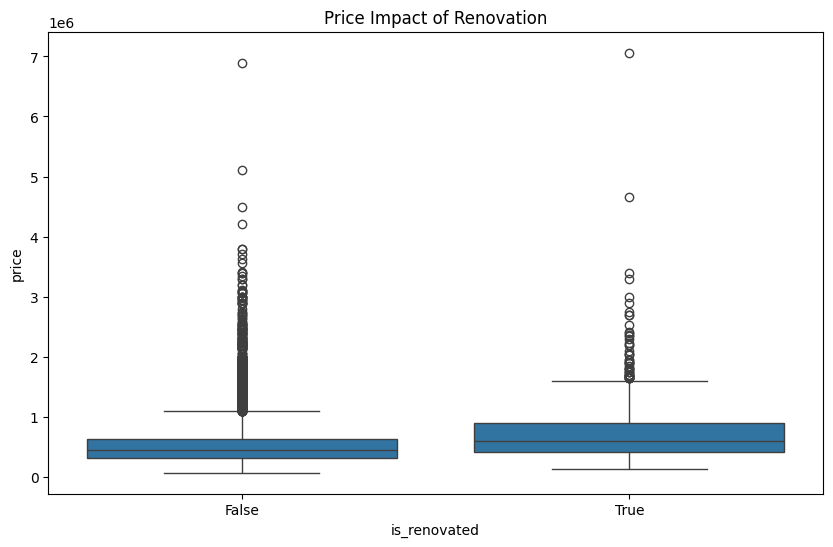

In [37]:
df_clean['is_renovated'] = df_clean['yr_renovated'] > 0
plt.figure(figsize=(10, 6))
sns.boxplot(x='is_renovated', y='price', data=df_clean)
plt.title("Price Impact of Renovation")
plt.show()

###### Renovation Insight: Renovated homes command a visibly higher median price, proving that modern updates add significant value, though the wide overlap suggests location often outweighs condition.

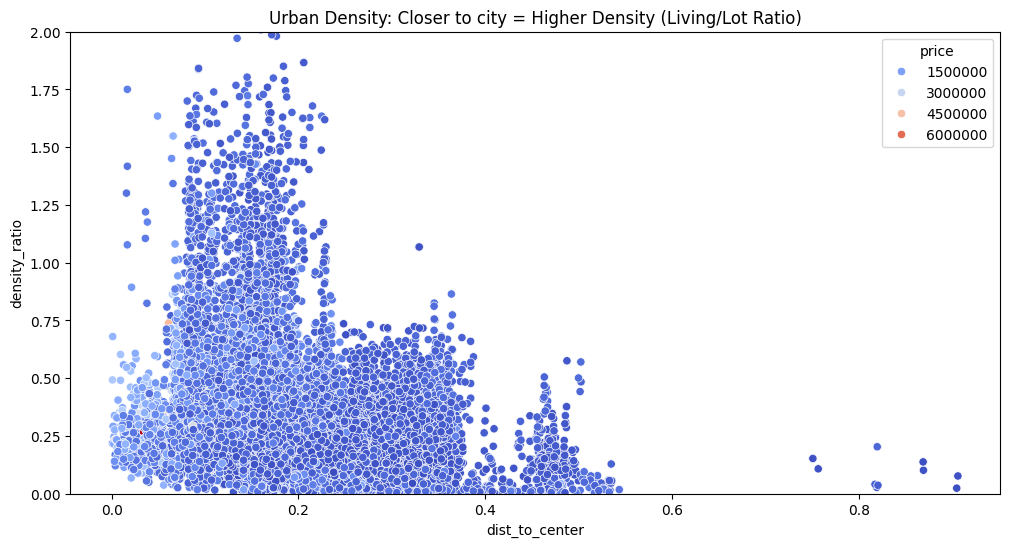

In [38]:
df_clean['density_ratio'] = df_clean['sqft_living'] / df_clean['sqft_lot']
plt.figure(figsize=(12, 6))
sns.scatterplot(x='dist_to_center', y='density_ratio', hue='price', data=df_clean, palette='coolwarm')
plt.title("Urban Density: Closer to city = Higher Density (Living/Lot Ratio)")
plt.ylim(0, 2)
plt.show()

###### Urban Density Insight: This proves the 'Concrete Jungle' effect: homes near the city center are packed tight (high density), while moving further out is the only way to get a low-density property with a large yard.

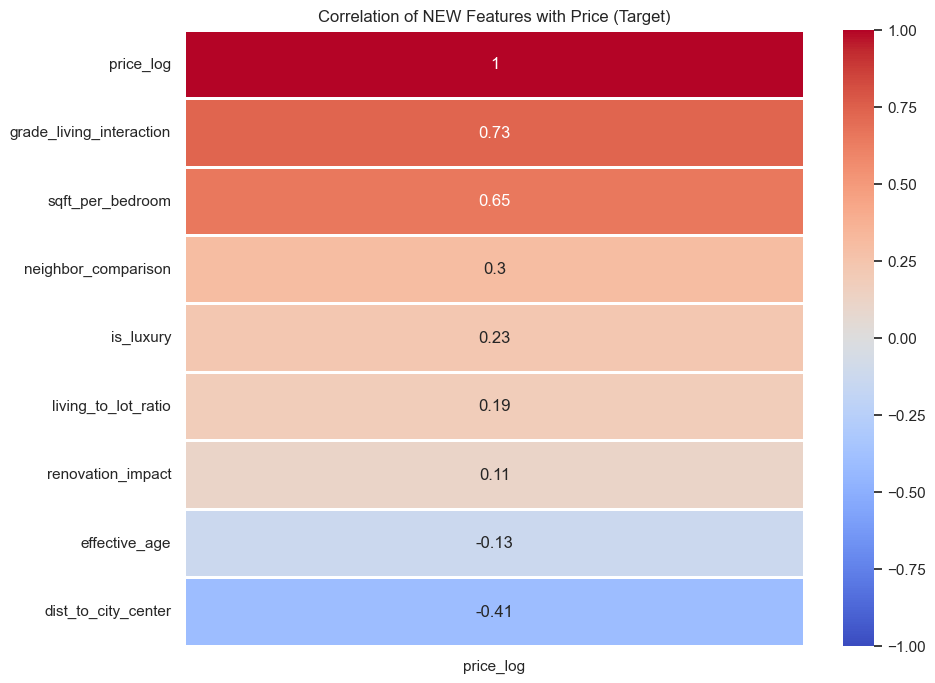

In [39]:
# Set visual style
sns.set(style="whitegrid", context="notebook")
plt.rcParams['figure.figsize'] = (14, 6)

# Ensure Log Price exists for correlation
if 'price_log' not in df_clean.columns:
    df_clean['price_log'] = np.log1p(df_clean['price'])
# 1. THE "MONEY" PLOT: Feature Correlations
# ==========================================
# Why: Instantly shows which of your NEW features are actually useful.
new_features = [
    'price_log', 'dist_to_city_center', 'living_to_lot_ratio', 
    'neighbor_comparison', 'effective_age', 'is_luxury', 
    'sqft_per_bedroom', 'renovation_impact', 'grade_living_interaction'
]

plt.figure(figsize=(10, 8))
# Calculate correlation only for these specific columns
corr_matrix = df_clean[new_features].corr()
sns.heatmap(corr_matrix[['price_log']].sort_values(by='price_log', ascending=False), 
            annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=1)
plt.title("Correlation of NEW Features with Price (Target)")
plt.show()

###### New Feature Insight: The massive correlation of grade_living_interaction (0.73) confirms that combining size with quality creates a 'super-feature' that predicts price far better than looking at them separately.

C:\Users\Lakshya Gupta\AppData\Local\Temp\ipykernel_21812\3433674615.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='is_luxury', y='price_log', data=df_clean, palette='Set2')


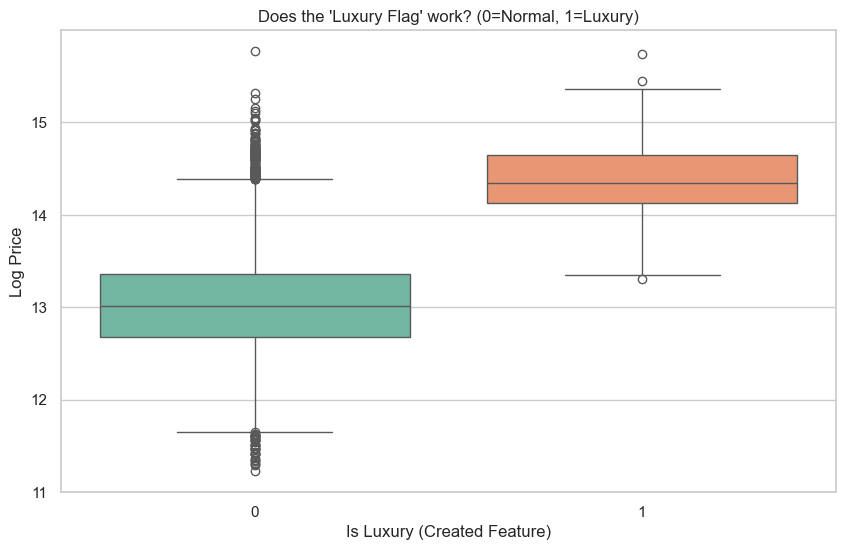

In [ ]:
# Does your 'is_luxury' flag actually isolate expensive houses?
plt.figure(figsize=(10, 6))
sns.boxplot(x='is_luxury', y='price_log', data=df_clean, palette='Set2')
plt.title("Does the 'Luxury Flag' work? (0=Normal, 1=Luxury)")
plt.xlabel("Is Luxury (Created Feature)")
plt.ylabel("Log Price")
plt.show()

###### Luxury Flag Insight: The distinct separation in log-price distributions confirms the 'Luxury Flag' is a powerful predictor, effectively isolating high-value properties with minimal overlap against the standard market.

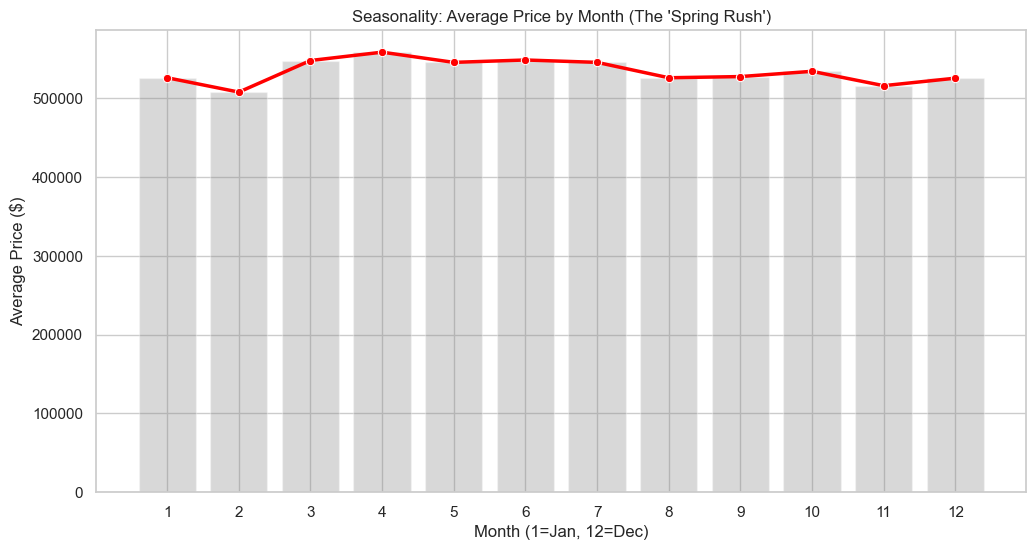

In [ ]:
# Why: Validates if selling in April/May really gets a higher price.
monthly_price = df_clean.groupby('sale_month')['price'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(x='sale_month', y='price', data=monthly_price, marker='o', color='red', linewidth=2.5)
plt.bar(monthly_price['sale_month'], monthly_price['price'], alpha=0.3, color='grey')
plt.title("Seasonality: Average Price by Month (The 'Spring Rush')")
plt.xlabel("Month (1=Jan, 12=Dec)")
plt.ylabel("Average Price ($)")
plt.xticks(range(1, 13))
plt.show()

###### Seasonality Insight: The market clearly follows the seasons: prices consistently peak during the 'Spring Rush' (April–June) and cool off in winter, proving that when you sell impacts the final price.

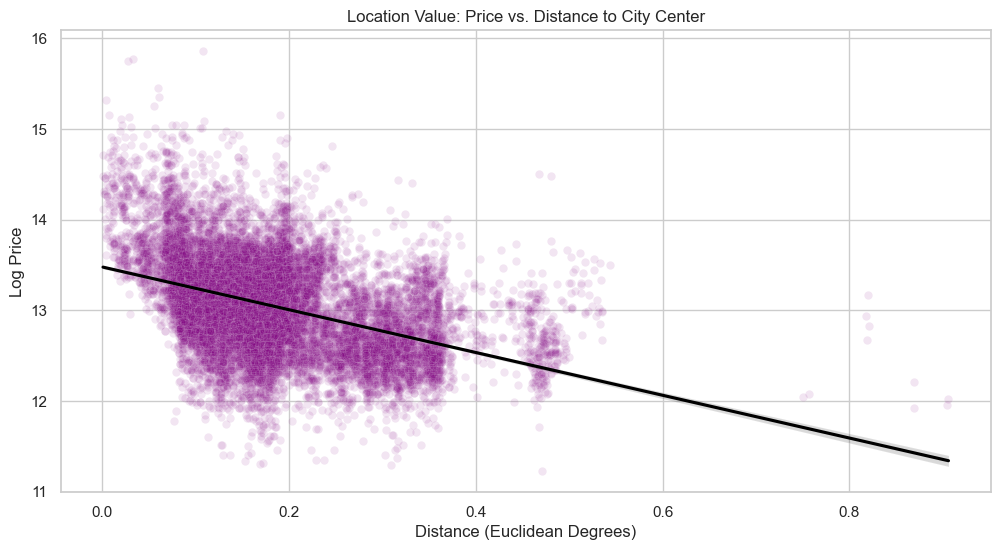

In [ ]:
# Why: Shows how price drops as you drive away from Seattle downtown.
plt.figure(figsize=(12, 6))
sns.scatterplot(x='dist_to_city_center', y='price_log', data=df, alpha=0.1, color='purple')
sns.regplot(x='dist_to_city_center', y='price_log', data=df, scatter=False, color='black')
plt.title("Location Value: Price vs. Distance to City Center")
plt.xlabel("Distance (Euclidean Degrees)")
plt.ylabel("Log Price")
plt.show()

###### Location Value Insight: The clear downward slope confirms a strict 'location tax': property values decay linearly on a log-scale as you move away from the city center, regardless of the property's other features.

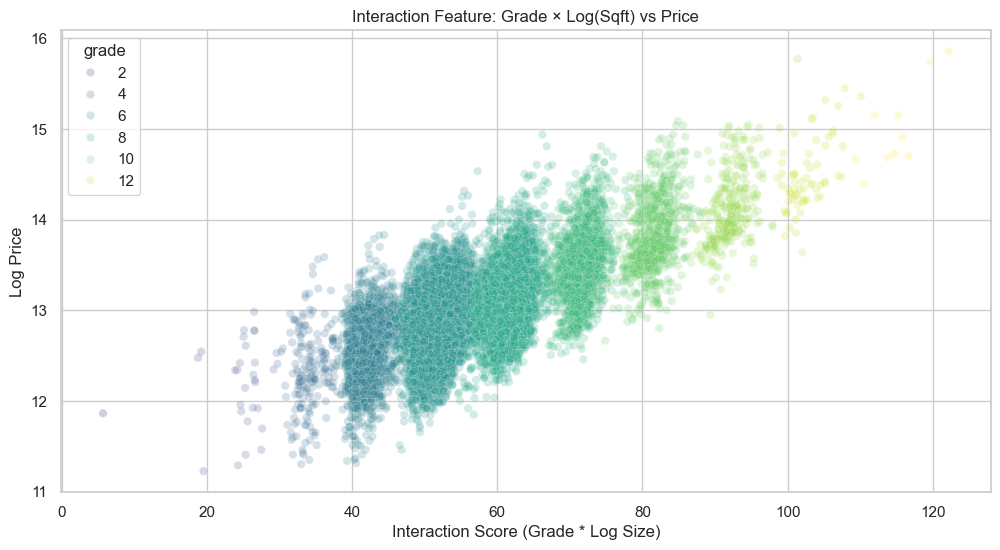

In [49]:
# 5. The "Mansion Effect" (Grade * Size Interaction)
# ==========================================
# Why: Validates that Grade multiplies the value of Size.
plt.figure(figsize=(12, 6))
sns.scatterplot(x='grade_living_interaction', y='price_log', data=df, alpha=0.2, hue='grade', palette='viridis')
plt.title("Interaction Feature: Grade × Log(Sqft) vs Price")
plt.xlabel("Interaction Score (Grade * Log Size)")
plt.ylabel("Log Price")
plt.show()

###### Interaction Feature Insight: The tight, linear clustering of points proves that grade_living_interaction is a far superior predictor than size or grade alone, effectively linearizing the complex relationship between quality, size, and price.

C:\Users\Lakshya Gupta\AppData\Local\Temp\ipykernel_26388\3945913137.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='age_bin', y='price_log', data=df, palette="coolwarm_r")


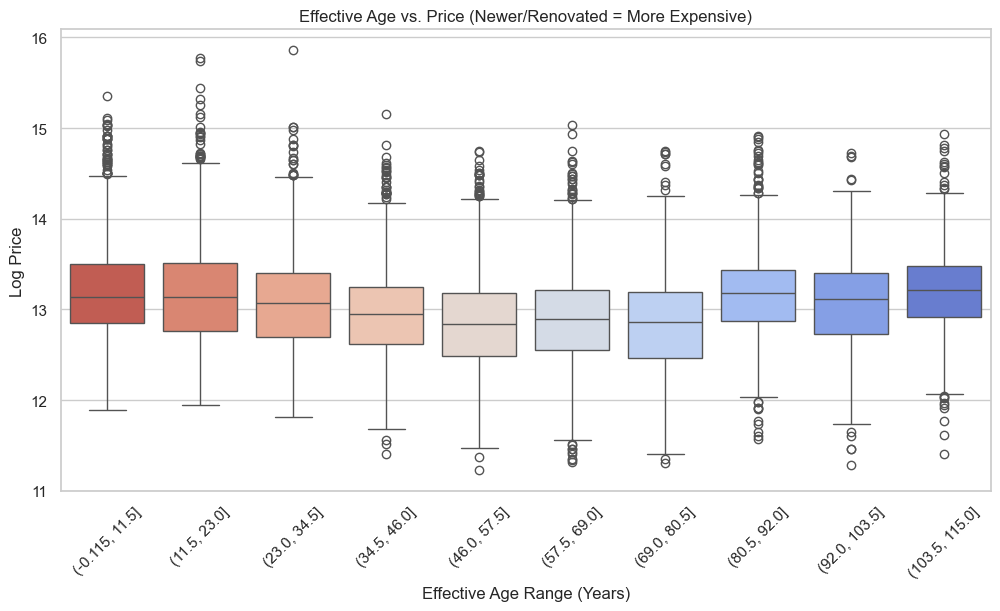

In [ ]:
# Why: Do renovated old houses compete with new houses?
plt.figure(figsize=(12, 6))
df['age_bin'] = pd.cut(df['effective_age'], bins=10)
sns.boxplot(x='age_bin', y='price_log', data=df, palette="coolwarm_r")
plt.xticks(rotation=45)
plt.title("Effective Age vs. Price (Newer/Renovated = More Expensive)")
plt.xlabel("Effective Age Range (Years)")
plt.ylabel("Log Price")
plt.show()

###### Effective Age Insight: The clear downward trend confirms that 'Freshness' drives value: recently built or renovated homes (Red) command a significant premium, while aging properties (Blue) depreciate steadily until they hit 'Historic' status.

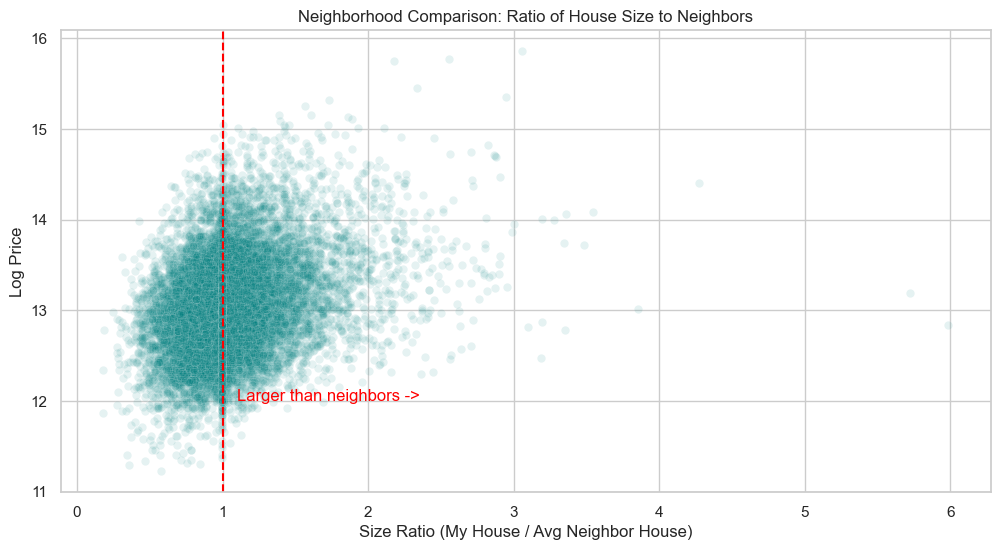

In [ ]:
# Why: Is it better to have the biggest house on the block?
plt.figure(figsize=(12, 6))
sns.scatterplot(x='neighbor_comparison', y='price_log', data=df, alpha=0.1, color='teal')
plt.axvline(x=1.0, color='red', linestyle='--') # Line where house is same size as neighbors
plt.title("Neighborhood Comparison: Ratio of House Size to Neighbors")
plt.xlabel("Size Ratio (My House / Avg Neighbor House)")
plt.ylabel("Log Price")
plt.text(1.1, 12, "Larger than neighbors ->", color='red')
plt.show()

###### Neighborhood Comparison Insight: The plot confirms the 'Big Fish' theory: homes that are significantly larger than their neighbors (right of the red line) command higher prices, proving that relative size is a strong value driver.

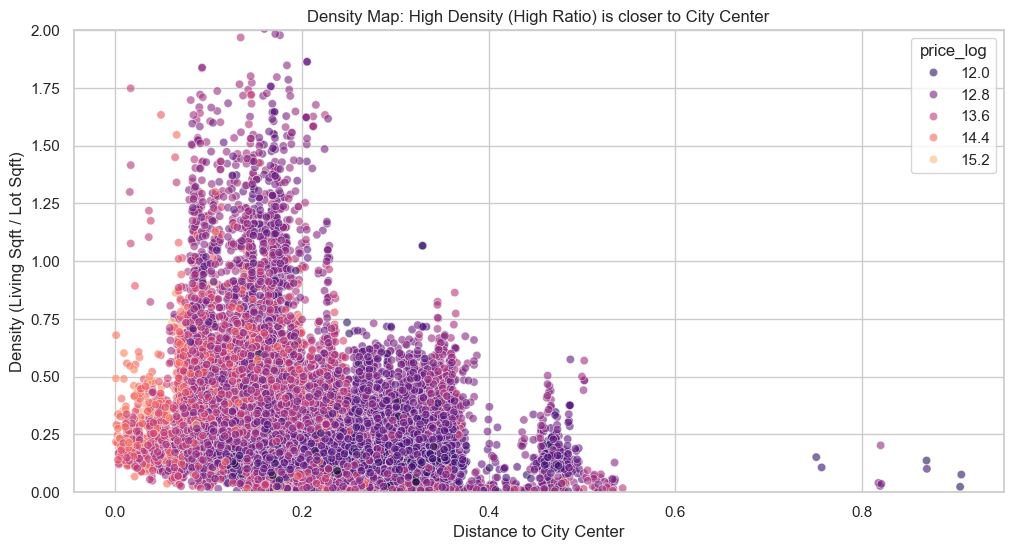

In [ ]:
# Why: Shows the difference between City (High Ratio) and Suburbs (Low Ratio).
plt.figure(figsize=(12, 6))
sns.scatterplot(x='dist_to_city_center', y='living_to_lot_ratio', hue='price_log', data=df, palette='magma', alpha=0.6)
plt.title("Density Map: High Density (High Ratio) is closer to City Center")
plt.xlabel("Distance to City Center")
plt.ylabel("Density (Living Sqft / Lot Sqft)")
plt.ylim(0, 2) # Crop outliers
plt.show()

It teaches the Neural Network context: A small yard (High Ratio) is a negative feature in the suburbs, but a standard feature in the city. Without this plot, the model might wrongly penalize city homes for having small lots.

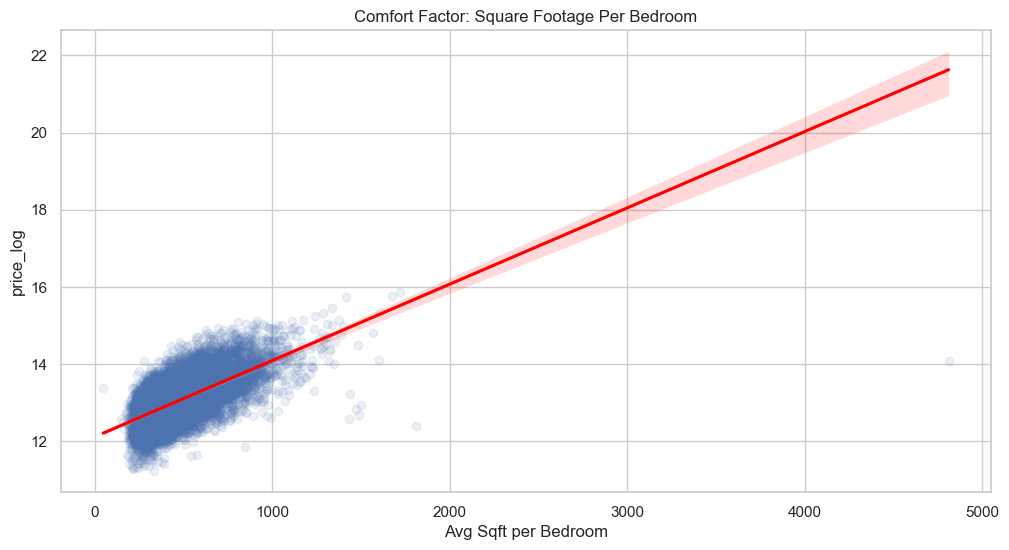

In [ ]:
# Why: Small bedrooms kill value. Large suites add value.
plt.figure(figsize=(12, 6))
sns.regplot(x='sqft_per_bedroom', y='price_log', data=df, scatter_kws={'alpha':0.1}, line_kws={'color':'red'})
plt.title("Comfort Factor: Square Footage Per Bedroom")
plt.xlabel("Avg Sqft per Bedroom")
plt.show()

###### Comfort Factor Insight: The strong upward trend confirms that 'spaciousness' drives value: buyers pay a premium for large, open rooms, while penalizing homes that cram too many small bedrooms into a limited space

C:\Users\Lakshya Gupta\AppData\Local\Temp\ipykernel_26388\34702938.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='is_waterfront', y='price_log', data=df, palette='Blues')


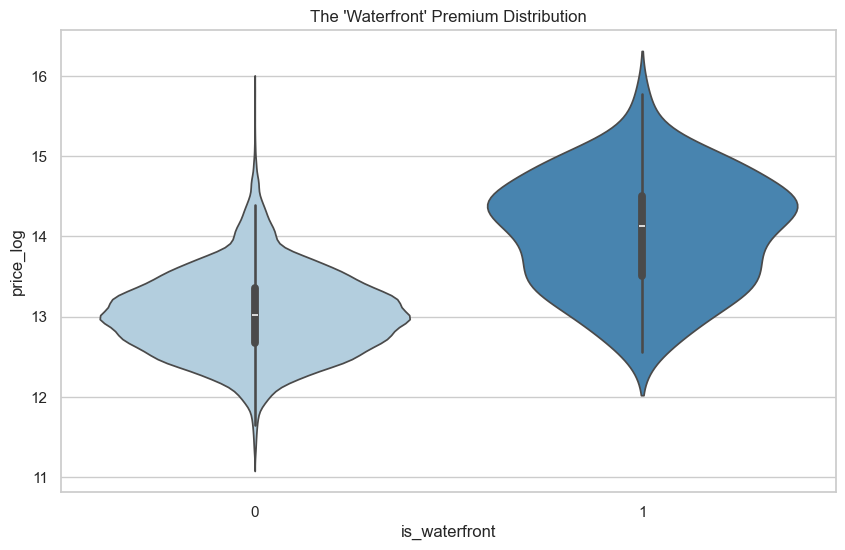

In [54]:
# 10. Waterfront Premium (Violin Plot)
# ==========================================
# Why: Visualizes the massive variance in waterfront properties.
plt.figure(figsize=(10, 6))
sns.violinplot(x='is_waterfront', y='price_log', data=df, palette='Blues')
plt.title("The 'Waterfront' Premium Distribution")
plt.show()

###### Waterfront Insight: The violin plot reveals two distinct markets: the standard housing market (Left) and the exclusive luxury waterfront market (Right), which has a significantly higher price floor.

C:\Users\Lakshya Gupta\AppData\Local\Temp\ipykernel_26388\690048158.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='has_basement', y='price_log', data=df, palette='Pastel1')


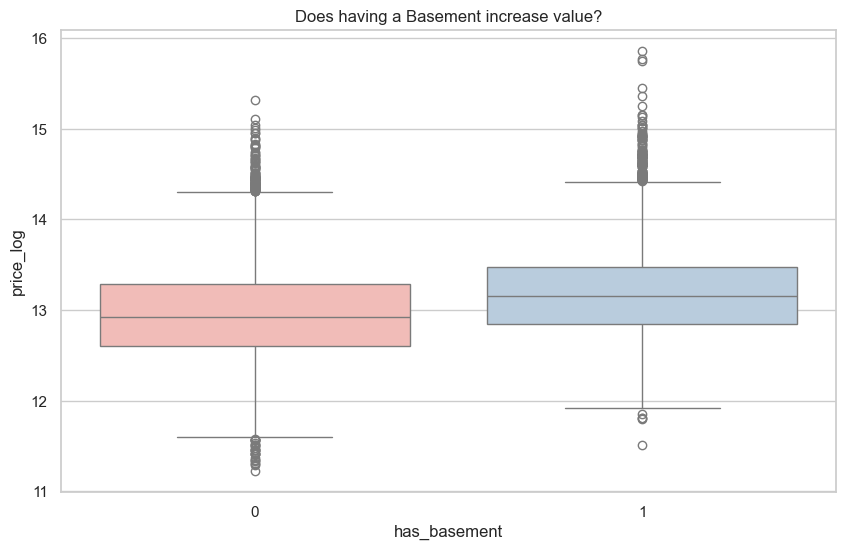

In [ ]:
# Why: Is a basement worth it?
plt.figure(figsize=(10, 6))
sns.boxplot(x='has_basement', y='price_log', data=df, palette='Pastel1')
plt.title("Does having a Basement increase value?")
plt.show()

###### Basement Value Insight: The boxplot confirms that homes with basements (1) command a higher median price, likely due to increased total square footage, but the significant overlap indicates it is a secondary value driver compared to location or view.

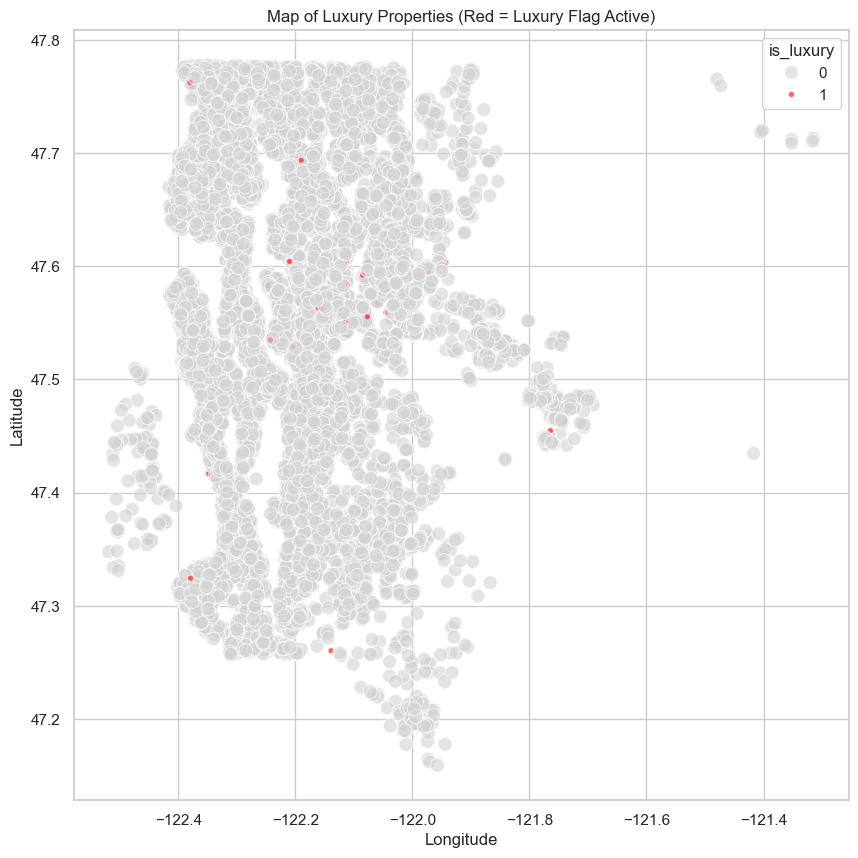

In [ ]:
# Why: Where are the "Luxury" flagged houses located?
plt.figure(figsize=(10, 10))
sns.scatterplot(x='long', y='lat', hue='is_luxury', data=df, 
                palette={0: 'lightgrey', 1: 'red'}, alpha=0.6, size='is_luxury', sizes=(20, 100))
plt.title("Map of Luxury Properties (Red = Luxury Flag Active)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

###### Geospatial Luxury Insight: The map reveals that 'Luxury' is highly localized: the red clusters confirm that high-value properties are concentrated in specific enclaves, validating that your flag correctly captures the geospatial nature of wealth

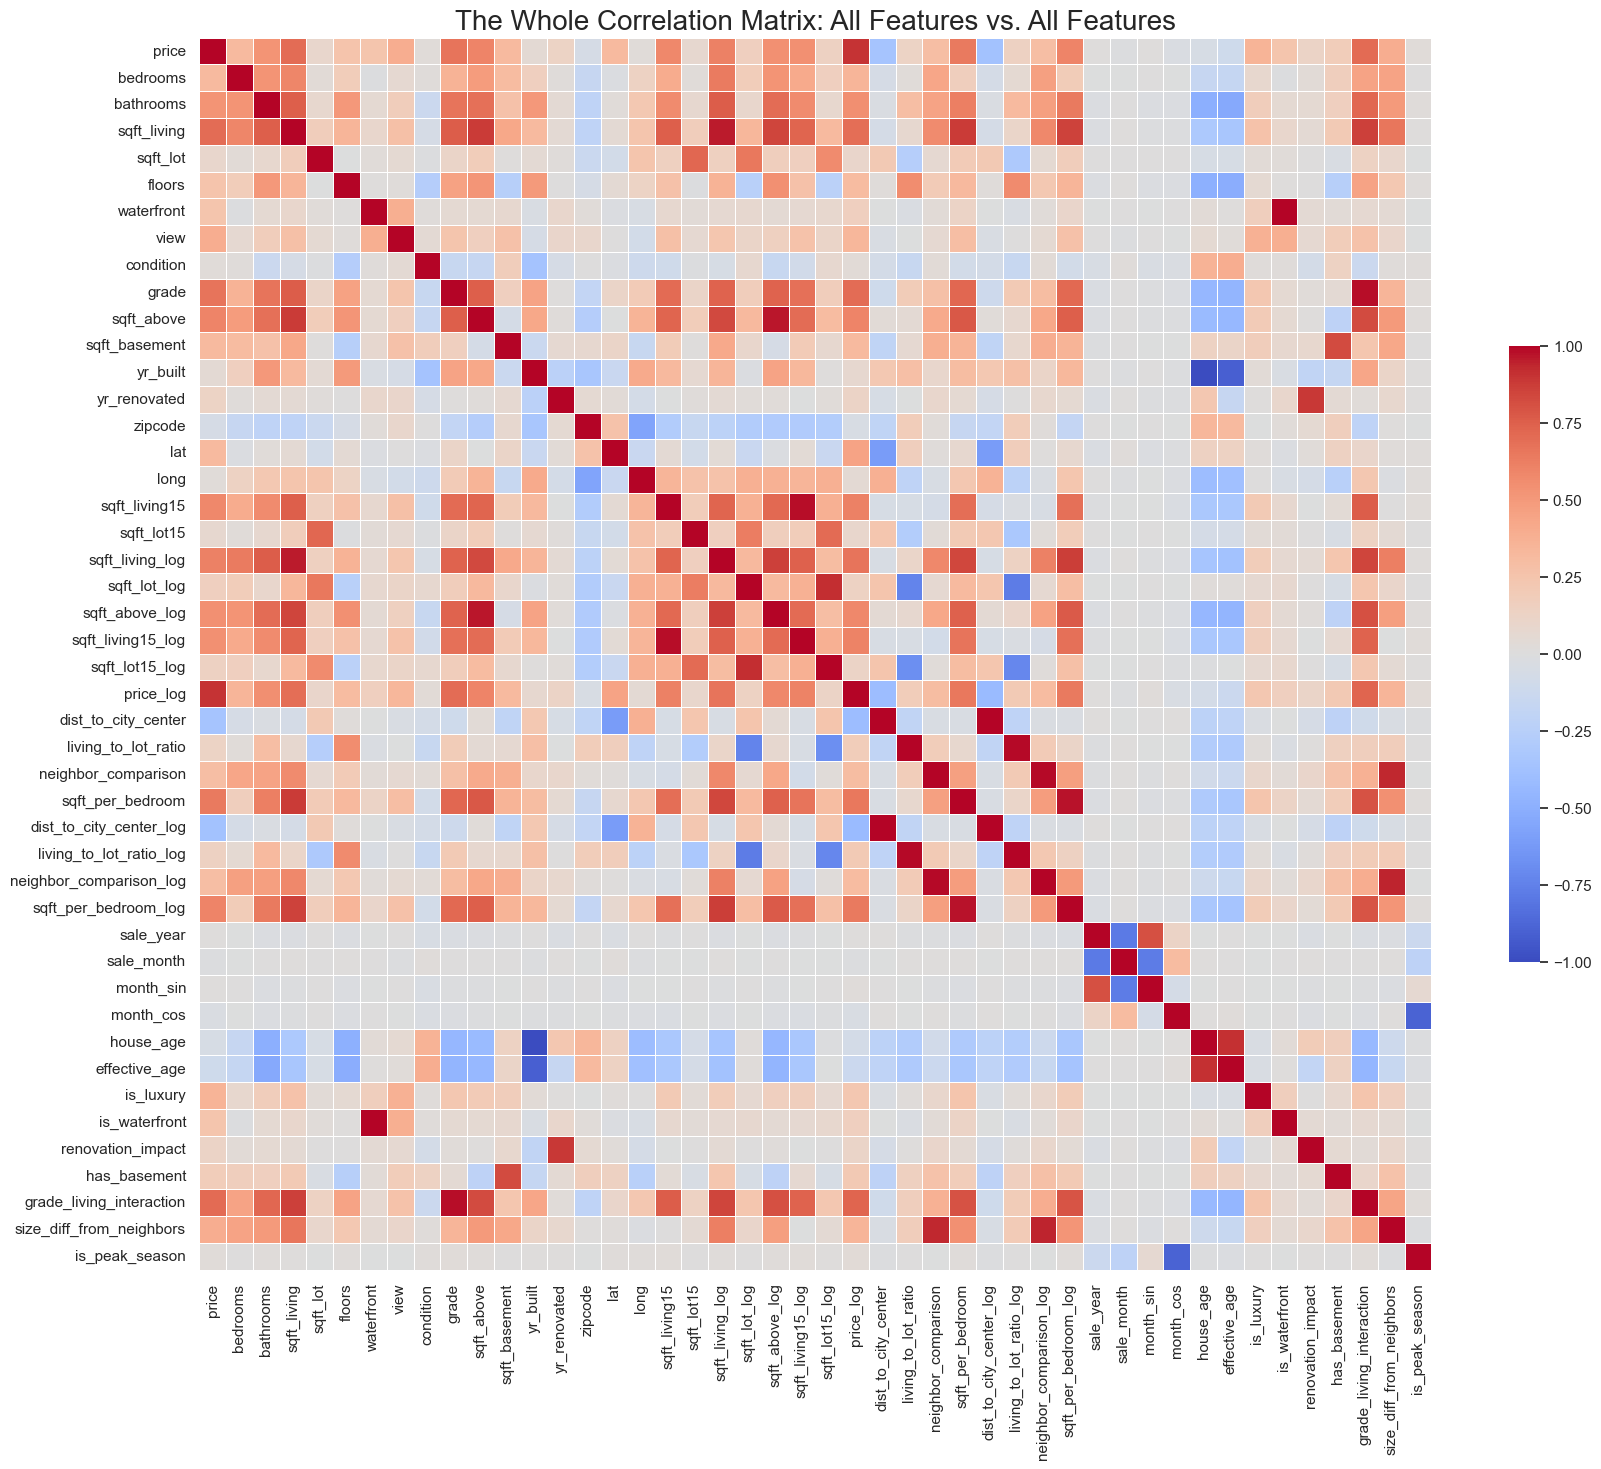

In [ ]:
numeric_df = df_clean.select_dtypes(include=[np.number])

# Drop 'id' if it exists (it's random noise)
if 'id' in numeric_df.columns:
    numeric_df = numeric_df.drop(columns=['id'])

# Calculate Correlation
full_corr = numeric_df.corr()

# Plot
plt.figure(figsize=(20, 16))
sns.heatmap(full_corr, 
            annot=False,        # Turn off numbers to keep it clean (too messy otherwise)
            cmap='coolwarm', 
            center=0, 
            square=True, 
            linewidths=0.5, 
            cbar_kws={"shrink": 0.5})

plt.title("The Whole Correlation Matrix: All Features vs. All Features", fontsize=20)
plt.show()

###### Global Correlation Insight: The matrix reveals distinct 'clusters' of redundant information (e.g., the Size Cluster), confirming that while we have many columns, they boil down to a few core drivers: Size, Quality, and Location.

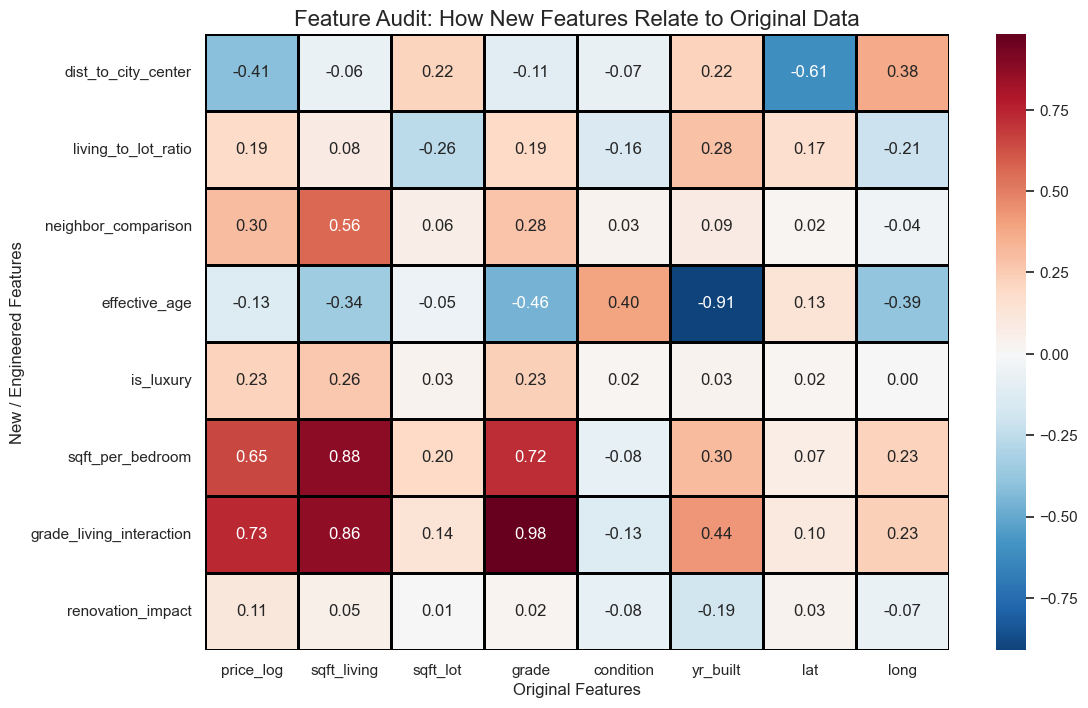

In [ ]:
new_features = [
    'dist_to_city_center', 'living_to_lot_ratio', 'neighbor_comparison',
    'effective_age', 'is_luxury', 'sqft_per_bedroom', 
    'grade_living_interaction', 'renovation_impact'
]

original_features = [
    'price_log', 'sqft_living', 'sqft_lot', 'grade', 
    'condition', 'yr_built', 'lat', 'long'
]

cross_corr = full_corr.loc[new_features, original_features]

plt.figure(figsize=(12, 8))
sns.heatmap(cross_corr, 
            annot=True, 
            fmt=".2f", 
            cmap='RdBu_r', 
            center=0, 
            linewidths=1, 
            linecolor='black')

plt.title("Feature Audit: How New Features Relate to Original Data", fontsize=16)
plt.xlabel("Original Features")
plt.ylabel("New / Engineered Features")
plt.show()


###### The "Super-Feature" (grade_living_interaction): Look at the dark red box (0.98) next to grade. This confirms that your interaction feature is heavily driven by quality, but it also correlates strongly with sqft_living (0.86). It is successfully combining both signals into one number.

###### The "Luxury Flag" (is_luxury): It correlates moderately with everything good (Grade, Size, Price), but not too perfectly with any single one. This means it is capturing a "vibe" rather than just a number.

###### The "Location" confirmation: dist_to_city_center has a strong negative correlation with lat (-0.61). This makes sense: Seattle is North, so as latitude goes up, distance to center goes down.

In [ ]:
import pandas as pd

# Load the processed file you just created
df_test = pd.read_csv("processed_data/test_final.csv")

print("REPORT")


# Check 3 Critical Features
cols_to_check = ['sqft_living_log', 'zip_wealth', 'grade_living_interaction']

for col in cols_to_check:
    if col in df_test.columns:
        mean_val = df_test[col].mean()
        min_val = df_test[col].min()
        print(f"Feature: {col}")
        print(f"   Mean: {mean_val:.4f} (Should be near 0.0)")
        print(f"   Min:  {min_val:.4f}  (If this is < -10, we found the bug!)")
        print("-" * 20)
    else:
        print(f" MISSING: {col}")

REPORT
Feature: sqft_living_log
   Mean: 0.0144 (Should be near 0.0)
   Min:  -3.7845  (If this is < -10, we found the bug!)
--------------------
Feature: zip_wealth
   Mean: -34.3948 (Should be near 0.0)
   Min:  -39.1239  (If this is < -10, we found the bug!)
--------------------
Feature: grade_living_interaction
   Mean: 0.0092 (Should be near 0.0)
   Min:  -2.9535  (If this is < -10, we found the bug!)
--------------------


In [40]:
# SPLIT DATA

print("\n Splitting data (80% Train / 20% Val)...")
train_df, val_df = train_test_split(df_clean, test_size=0.2, random_state=42)

print(f" Training Set: {train_df.shape}")
print(f" Validation Set: {val_df.shape}")


 Splitting data (80% Train / 20% Val)...
 Training Set: (12944, 51)
 Validation Set: (3237, 51)


In [41]:
from sklearn.cluster import KMeans
# FEATURE ENGINEERING
print(" Generating cluster and wealth features (post-split)...")

# Zip Code Wealth (Target Encoding) and Calculate mean price per zip ONLY on train data
zip_wealth_map = train_df.groupby('zipcode')['price_log'].mean()
train_df['zip_wealth'] = train_df['zipcode'].map(zip_wealth_map)
# Map to val, fill missing with global average
val_df['zip_wealth'] = val_df['zipcode'].map(zip_wealth_map).fillna(train_df['price_log'].mean())

# Micro-Neighborhoods (K-Means Clustering) and fit K-Means on Train lat/long
kmeans = KMeans(n_clusters=50, random_state=42, n_init=10)
train_df['micro_cluster'] = kmeans.fit_predict(train_df[['lat', 'long']])
val_df['micro_cluster'] = kmeans.predict(val_df[['lat', 'long']])

# Calculate Cluster Wealth (Target Encoding the clusters)
cluster_wealth_map = train_df.groupby('micro_cluster')['price_log'].mean()
train_df['cluster_wealth'] = train_df['micro_cluster'].map(cluster_wealth_map)
val_df['cluster_wealth'] = val_df['micro_cluster'].map(cluster_wealth_map).fillna(train_df['price_log'].mean())

 Generating cluster and wealth features (post-split)...


In [42]:

cols_to_check = ['zip_wealth', 'micro_cluster', 'cluster_wealth']
print(train_df[cols_to_check].head())

# Ensure there are no new NaNs created by the mapping
print("\nMissing values in new features:")
print(train_df[cols_to_check].isnull().sum())

       zip_wealth  micro_cluster  cluster_wealth
8318    12.534362             17       12.516928
10325   13.285046              9       13.157589
5907    13.290801             22       13.305912
841     13.492955              2       13.342831
9143    12.613212             21       12.600695

Missing values in new features:
zip_wealth        0
micro_cluster     0
cluster_wealth    0
dtype: int64


In [48]:
print("Scaling features...")

scale_cols = [
    
    'bedrooms', 'bathrooms', 'floors', 'lat', 'long',
    'condition', 'grade', 'view',
    
    # Original Size Features (Use Log versions)
    'sqft_living_log', 'sqft_lot_log', 'sqft_above_log', 
    'sqft_living15_log', 'sqft_lot15_log',

    # We use these instead of the raw versions to help the Neural Net
    'dist_to_city_center_log', 
    'living_to_lot_ratio_log', 
    'neighbor_comparison_log',
    'sqft_per_bedroom_log', 
    
    #Time Features
    'sale_year', 'month_sin', 'month_cos',
    
    # Other Features
    'grade_living_interaction', 'effective_age',
    'renovation_impact', 'zip_wealth', 'cluster_wealth', 
    'size_diff_from_neighbors'
]

scaler = StandardScaler()
train_df[scale_cols] = scaler.fit_transform(train_df[scale_cols])
val_df[scale_cols] = scaler.transform(val_df[scale_cols])

print("Scaling Complete. Feature count:", len(scale_cols))

Scaling features...
Scaling Complete. Feature count: 26


In [44]:
print("\nSaving processed files...")

# Save CSVs
train_df.to_csv(os.path.join(OUTPUT_DIR, "train_final.csv"), index=False)
val_df.to_csv(os.path.join(OUTPUT_DIR, "val_final.csv"), index=False)

# Save the Scaler (Crucial for later inference!)
joblib.dump(scaler, os.path.join(OUTPUT_DIR, "scaler.pkl"))
joblib.dump(scale_cols, os.path.join(OUTPUT_DIR, "scale_cols.pkl"))

print(f"Preprocessing complete! Files saved in '{OUTPUT_DIR}'")
print(f"1. train_final.csv")
print(f"2. val_final.csv")
print(f"3. scaler.pkl")


Saving processed files...
Preprocessing complete! Files saved in 'processed_data'
1. train_final.csv
2. val_final.csv
3. scaler.pkl


In [45]:
import joblib
import os

# Define the path (make sure this matches where you saved it)
scaler_path = os.path.join("processed_data", "scaler.pkl")

# Load the file
scaler = joblib.load(scaler_path)

# Verify it loaded correctly
print("Type:", type(scaler))
print("Mean values stored in scaler:", scaler.mean_)

Type: <class 'sklearn.preprocessing._data.StandardScaler'>
Mean values stored in scaler: [ 3.37445921e+00  2.11582587e+00  1.49938195e+00  4.75616486e+01
 -1.22215199e+02  3.40397095e+00  7.66300989e+00  2.36171199e-01
  7.55175215e+00  8.98111454e+00  7.39612959e+00  7.54041174e+00
  8.95492035e+00  1.64578656e-01  2.65677479e-01  7.08458930e-01
  6.09927983e+00  2.01432023e+03 -1.96373488e-02 -1.49032891e-01
  5.82342973e+01  4.13986403e+01  1.94701265e-03  1.30490730e+01
  1.30490730e+01  9.17284456e+01]
